In [4]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.3 MB 24.4 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import math
import seaborn as sn
import plotly.express as px
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# Model Performance Metric Functions

In [3]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

def r2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2)/np.sum((y - np.mean(y))**2)

def mape(y, y_pred):
    return (np.mean(np.divide(np.absolute(np.subtract(y,y_pred)), y))*100)

def errors(y, y_pred):
    return np.absolute(y - y_pred)

# Model Building Function

In [4]:
def build_models(dataset, outlier_removal_lower_percentile, seed):
    #filter outliers
    dataset = dataset[(dataset['Yield_kg_per_Ha'] > dataset['Yield_kg_per_Ha'].quantile(outlier_removal_lower_percentile)) \
                                                                   & (dataset['Yield_kg_per_Ha'] < dataset['Yield_kg_per_Ha'].quantile(1-outlier_removal_lower_percentile))].reset_index(drop = True)

    #train/test split
    train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(dataset, test_size = 0.2, random_state = seed)

    #x values
    X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
    X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
    standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
    X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)
    power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
    X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)
    X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
    X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

    #y_values
    y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)
    mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()
    y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)
    standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))
    y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)
    power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)
    y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)
    y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)
    y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

    ####Initialize K fold Cross validation
    kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

    #####Grid Space for Lasso, Ridge, ElasticNet
    alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
    e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

    ####Model Building
#     model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
    model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'GBR', 'XGBoost']
    models = [linear_model.LinearRegression(), \
                LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                      RidgeCV(alphas = alphas_alt, cv = kfolds), \
                      ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                      SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
#                       LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
#                                     bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                      GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                                min_samples_split = 10, loss = 'huber', random_state = 42), \
                      XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                                   colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
             ]

    fitted_models = []
    Test_MAE_models = []
    Test_RMSE_models = []
    Test_R2_models = []
    Test_mape_models = []

    for model in models:
        fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
        inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
        inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
        Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
        Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
        Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
        Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))

    for model_name in model_names:
        print(model_name)
        print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
        print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
        print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
        print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
        inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
        inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
        fig, ax = plt.subplots()
        ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
        ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        plt.xlabel('Actual Target')
        plt.ylabel('Predicted Target')
        plt.title(model_name + ' (Target: Yield kg per ha)')
        plt.legend()
        plt.show()
    return Test_R2_models[6]

# Importing Datasets

In [4]:
df_summer_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_summer_combined_parents.csv').drop(columns = 'Unnamed: 0')

In [5]:
df_winter_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_winter_combined_parents.csv').drop(columns = 'Unnamed: 0')

In [6]:
df_dy_wy_ratio_summer_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_summer_combined_parents.csv').drop(columns = 'Unnamed: 0')

In [7]:
df_dy_wy_ratio_winter_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_winter_combined_parents.csv').drop(columns = 'Unnamed: 0')

## Model Building Dataset 1: Summer Combined Parents

[16:53:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1727.3977659771906
RMSE on test data: 2245.8693382789834
R squared on test data: -0.02562707031546796
MAPE on test data: 29.46416643116295


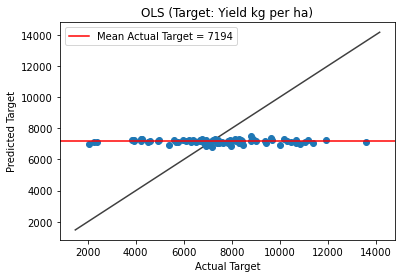

Lasso
MAE on test data: 1726.2585705663348
RMSE on test data: 2245.4682571463427
R squared on test data: -0.02526077746979727
MAPE on test data: 29.45067251476341


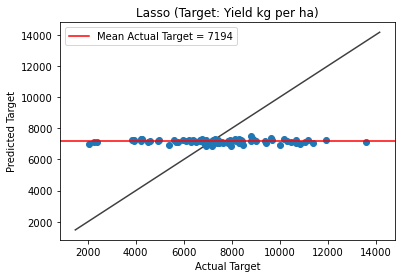

Ridge
MAE on test data: 1726.1539746894812
RMSE on test data: 2245.075034413428
R squared on test data: -0.02490172492600151
MAPE on test data: 29.451986041773264


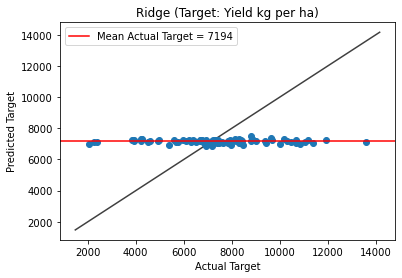

ElasticNet
MAE on test data: 1726.3675133653264
RMSE on test data: 2245.518867718655
R squared on test data: -0.025306994662416038
MAPE on test data: 29.45193335257868


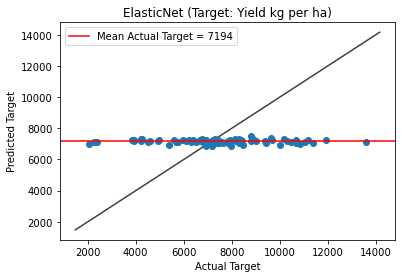

SVR
MAE on test data: 1711.3150865188193
RMSE on test data: 2229.9922243760493
R squared on test data: -0.01117704163858435
MAPE on test data: 29.321536833255113


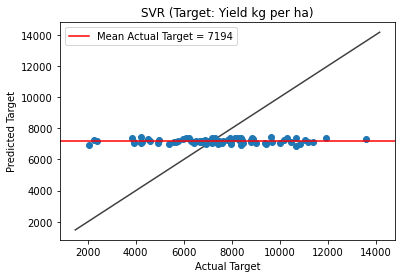

GBR
MAE on test data: 2025.3226746608736
RMSE on test data: 2523.5546459090715
R squared on test data: -0.29492891990793435
MAPE on test data: 32.42471453476578


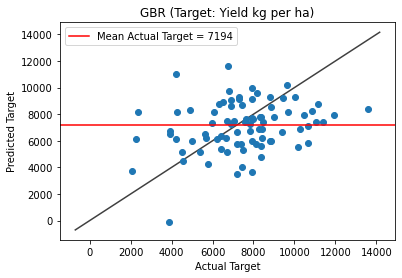

XGBoost
MAE on test data: 1816.7108279612207
RMSE on test data: 2236.069007218915
R squared on test data: -0.01669551427104854
MAPE on test data: 28.35916018700228


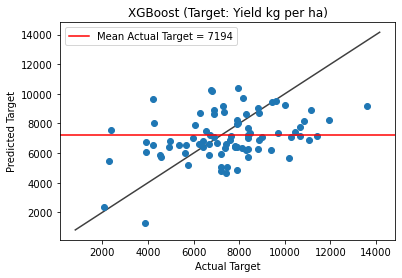

[16:53:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1776.4853197966897
RMSE on test data: 2266.87126657005
R squared on test data: -0.06968678261307804
MAPE on test data: 35.32240988044367


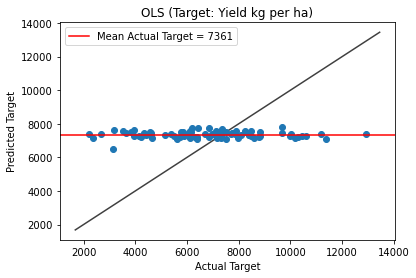

Lasso
MAE on test data: 1776.4382243466873
RMSE on test data: 2266.351779243392
R squared on test data: -0.0691965694606338
MAPE on test data: 35.3197949698023


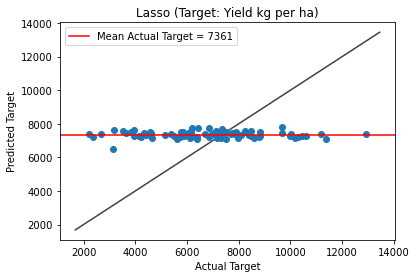

Ridge
MAE on test data: 1776.2479812083727
RMSE on test data: 2266.233708410422
R squared on test data: -0.06908516783065344
MAPE on test data: 35.32299800735277


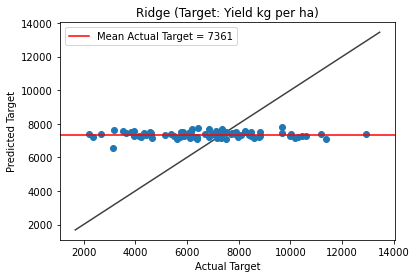

ElasticNet
MAE on test data: 1776.4440912931632
RMSE on test data: 2266.4161433272675
R squared on test data: -0.06925730039880085
MAPE on test data: 35.32012171167691


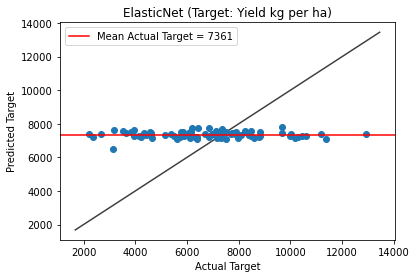

SVR
MAE on test data: 1805.253952229552
RMSE on test data: 2297.165751828279
R squared on test data: -0.09846843013156459
MAPE on test data: 35.94599513637915


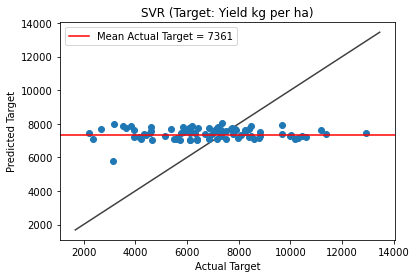

GBR
MAE on test data: 1798.9903809335622
RMSE on test data: 2339.392958128977
R squared on test data: -0.13922438077163424
MAPE on test data: 33.54246061191412


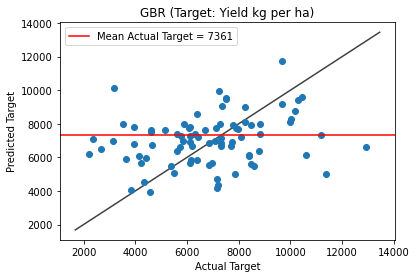

XGBoost
MAE on test data: 1737.0932700920443
RMSE on test data: 2260.886259180076
R squared on test data: -0.0640458518876037
MAPE on test data: 33.07510225780885


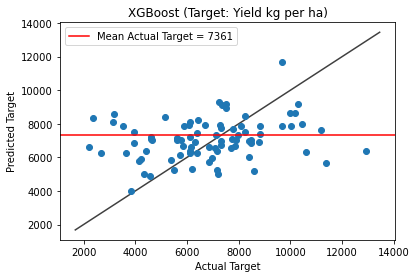

[16:53:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1769.9763783002668
RMSE on test data: 2125.1078257571703
R squared on test data: -0.08072379494605175
MAPE on test data: 27.45186547710689


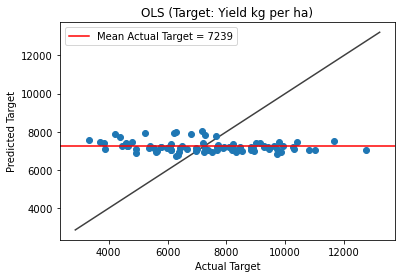

Lasso
MAE on test data: 1768.829637548585
RMSE on test data: 2124.0308929857906
R squared on test data: -0.07962872395407561
MAPE on test data: 27.43232893542506


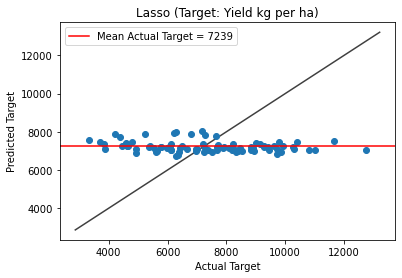

Ridge
MAE on test data: 1765.3612038403064
RMSE on test data: 2120.413036533241
R squared on test data: -0.07595399844245487
MAPE on test data: 27.383164974681268


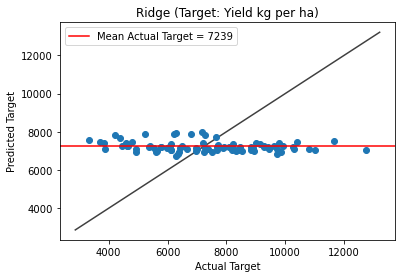

ElasticNet
MAE on test data: 1768.9730536458378
RMSE on test data: 2124.165055546354
R squared on test data: -0.07976511587668789
MAPE on test data: 27.434772024162147


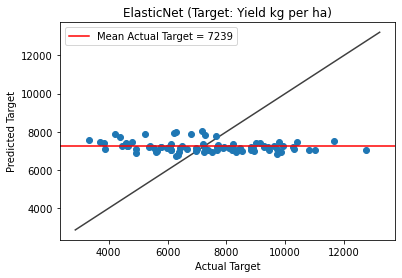

SVR
MAE on test data: 1762.2377097651342
RMSE on test data: 2135.3681388324753
R squared on test data: -0.091184754062682
MAPE on test data: 27.42381811300868


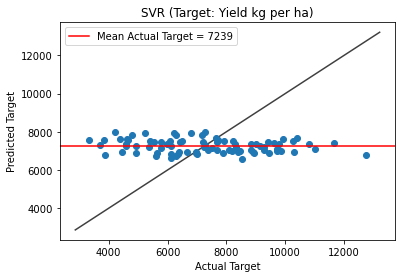

GBR
MAE on test data: 2032.181921580422
RMSE on test data: 2566.9149413170726
R squared on test data: -0.5767967941550687
MAPE on test data: 28.34365204292222


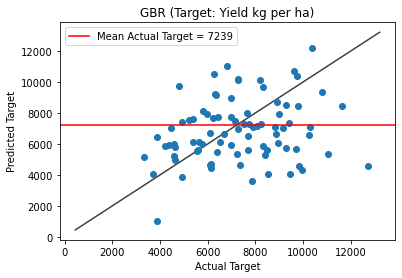

XGBoost
MAE on test data: 1843.427056589086
RMSE on test data: 2407.0094319050654
R squared on test data: -0.38646323120489123
MAPE on test data: 25.750777998500112


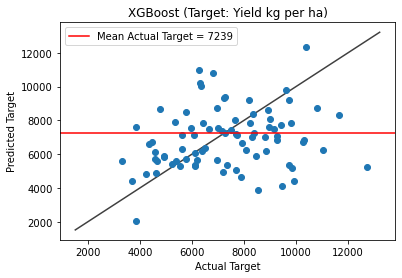

[16:54:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1853.4190954075862
RMSE on test data: 2338.8910070215884
R squared on test data: -0.027844595644430425
MAPE on test data: 34.48841100695147


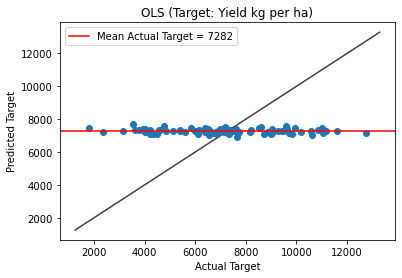

Lasso
MAE on test data: 1851.853138612903
RMSE on test data: 2337.3055381523804
R squared on test data: -0.02645157367937001
MAPE on test data: 34.4576236096233


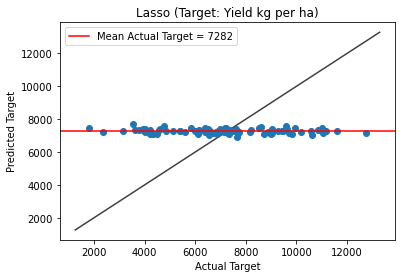

Ridge
MAE on test data: 1851.2486009304002
RMSE on test data: 2336.7562783475446
R squared on test data: -0.025969204269367774
MAPE on test data: 34.44724614309684


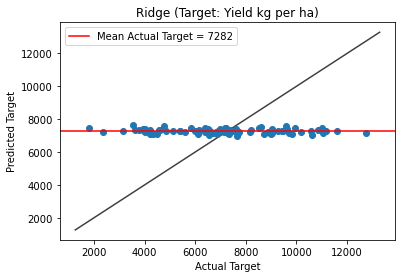

ElasticNet
MAE on test data: 1852.0489085634956
RMSE on test data: 2337.503195904294
R squared on test data: -0.02662518785678425
MAPE on test data: 34.46147248247011


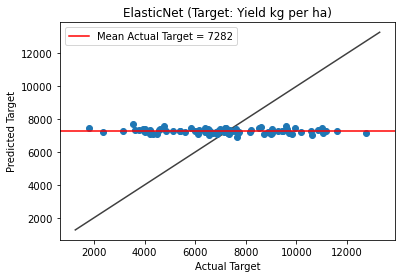

SVR
MAE on test data: 1867.6049528794458
RMSE on test data: 2355.4069265197086
R squared on test data: -0.04241195707317691
MAPE on test data: 34.695261931670025


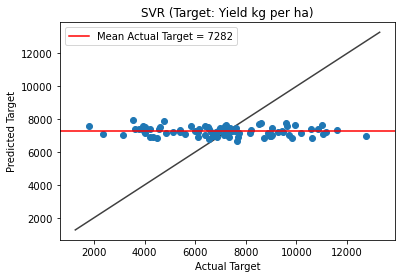

GBR
MAE on test data: 2009.6467461620678
RMSE on test data: 2479.7202369308047
R squared on test data: -0.15534811807086157
MAPE on test data: 33.02557646381341


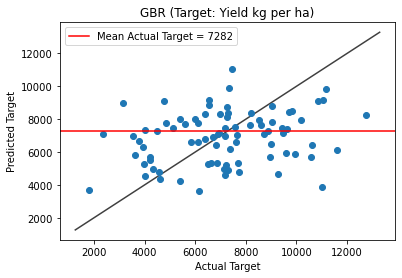

XGBoost
MAE on test data: 1910.5563215139705
RMSE on test data: 2379.516627854968
R squared on test data: -0.06386121594778493
MAPE on test data: 32.582159949441994


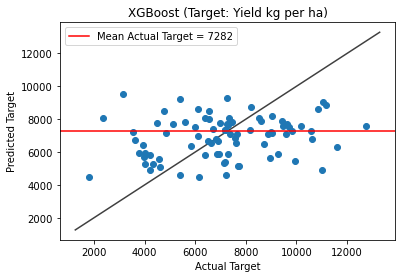

[16:54:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1386.9837443434214
RMSE on test data: 1692.843612014012
R squared on test data: -0.06098024783959288
MAPE on test data: 22.309618618032857


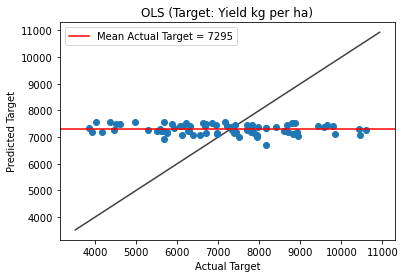

Lasso
MAE on test data: 1386.2411029125626
RMSE on test data: 1691.8391287523664
R squared on test data: -0.0597215128873807
MAPE on test data: 22.294645379896018


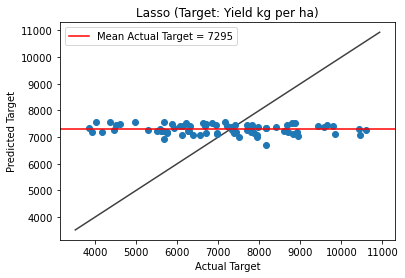

Ridge
MAE on test data: 1384.371186240035
RMSE on test data: 1689.9409520077365
R squared on test data: -0.057344915415625586
MAPE on test data: 22.2637396797192


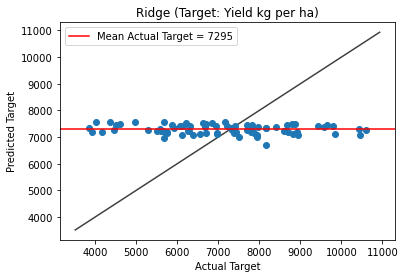

ElasticNet
MAE on test data: 1386.3339234123878
RMSE on test data: 1691.964331972561
R squared on test data: -0.05987836640037458
MAPE on test data: 22.296516916765206


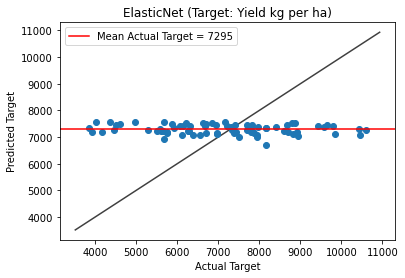

SVR
MAE on test data: 1390.7213593723845
RMSE on test data: 1698.904841807188
R squared on test data: -0.0685915332164928
MAPE on test data: 22.286747926304997


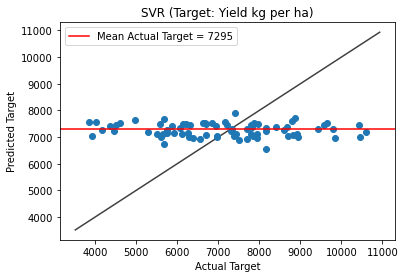

GBR
MAE on test data: 1523.9428288003764
RMSE on test data: 1962.0117312456891
R squared on test data: -0.42520330316652233
MAPE on test data: 24.04664305867726


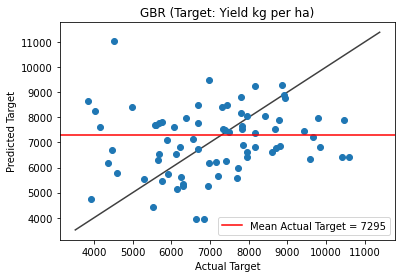

XGBoost
MAE on test data: 1502.5565322468638
RMSE on test data: 1960.285399897661
R squared on test data: -0.4226963959079555
MAPE on test data: 23.727614543286723


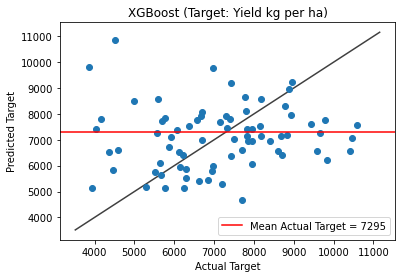

[16:54:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1480.841603110877
RMSE on test data: 1801.9422584157148
R squared on test data: -0.0857647390021905
MAPE on test data: 24.02534468165742


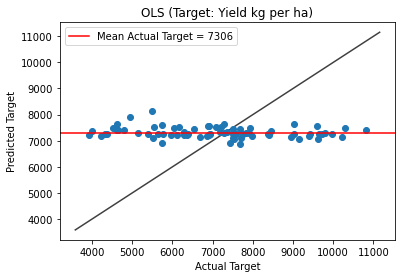

Lasso
MAE on test data: 1480.2873501269987
RMSE on test data: 1801.3833192555508
R squared on test data: -0.08509126313922799
MAPE on test data: 24.016046295331257


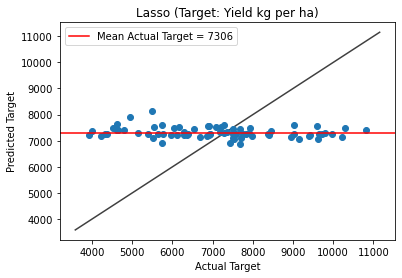

Ridge
MAE on test data: 1477.1060325786545
RMSE on test data: 1797.9458567700935
R squared on test data: -0.08095399635083411
MAPE on test data: 23.963355637278397


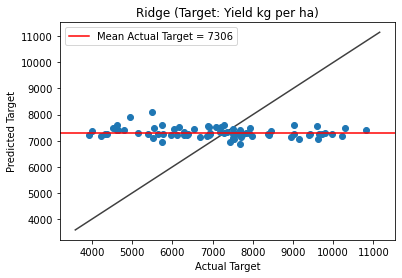

ElasticNet
MAE on test data: 1480.3566517194631
RMSE on test data: 1801.4529775579006
R squared on test data: -0.0851751842857158
MAPE on test data: 24.017208897497312


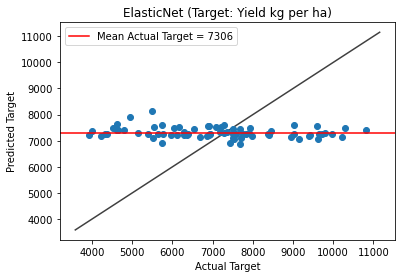

SVR
MAE on test data: 1500.4579787478672
RMSE on test data: 1827.8110625646812
R squared on test data: -0.117163134603256
MAPE on test data: 24.21255842367149


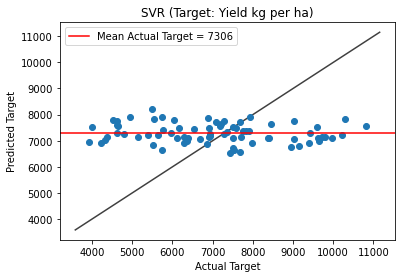

GBR
MAE on test data: 1601.9068881973296
RMSE on test data: 1904.3411568254976
R squared on test data: -0.21267241869016495
MAPE on test data: 24.326903050815137


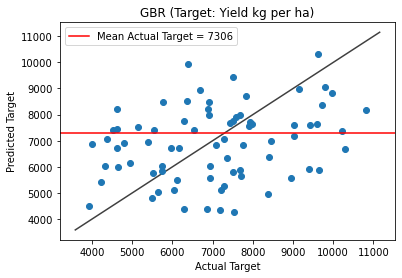

XGBoost
MAE on test data: 1588.8569732312415
RMSE on test data: 1864.7646545758741
R squared on test data: -0.16279204120325552
MAPE on test data: 24.65377681600798


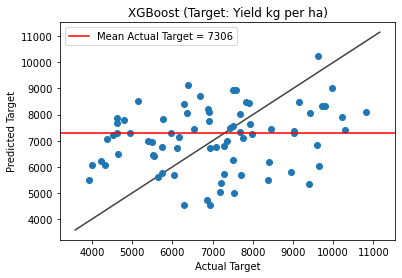

[16:55:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1524.8100357119827
RMSE on test data: 1812.7853397992492
R squared on test data: -0.08304345928350632
MAPE on test data: 21.910173028575183


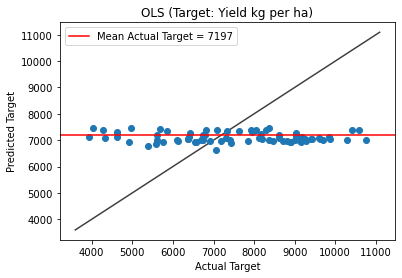

Lasso
MAE on test data: 1524.4260672291489
RMSE on test data: 1812.2326071251439
R squared on test data: -0.08238310283619699
MAPE on test data: 21.904310438204547


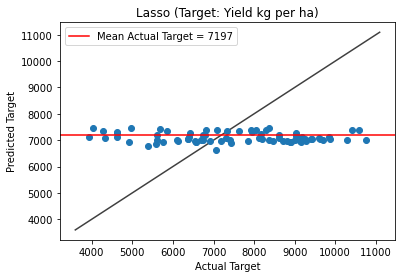

Ridge
MAE on test data: 1523.2161691377119
RMSE on test data: 1810.4466472017793
R squared on test data: -0.08025077136638847
MAPE on test data: 21.8888647341046


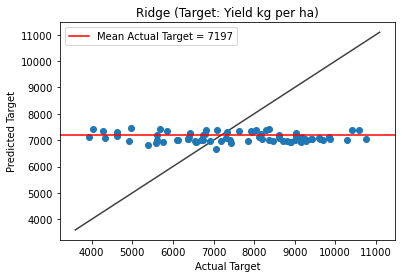

ElasticNet
MAE on test data: 1524.4740592003996
RMSE on test data: 1812.301429572262
R squared on test data: -0.08246531487459086
MAPE on test data: 21.905043109382586


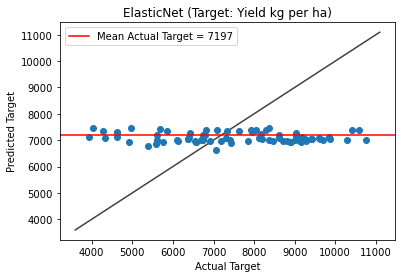

SVR
MAE on test data: 1524.5928914777892
RMSE on test data: 1823.1017921721343
R squared on test data: -0.09540560600674963
MAPE on test data: 21.943088646590382


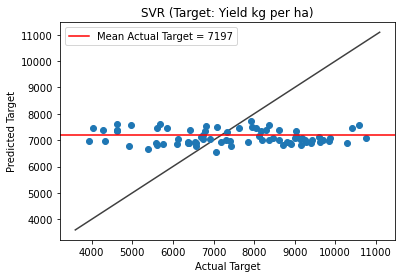

GBR
MAE on test data: 1637.7477877808628
RMSE on test data: 1975.5297835067422
R squared on test data: -0.28623489131484514
MAPE on test data: 23.800667833431273


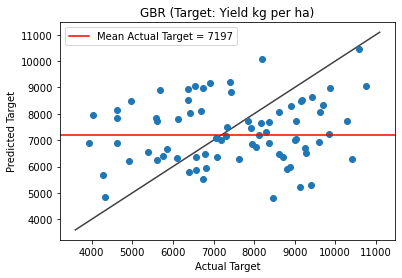

XGBoost
MAE on test data: 1572.3410624998016
RMSE on test data: 1917.1764621999198
R squared on test data: -0.21137135550411035
MAPE on test data: 22.64111923746686


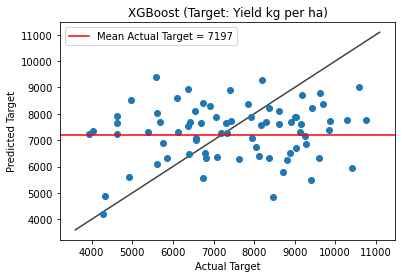

[16:55:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1461.4565587286297
RMSE on test data: 1788.4638574814528
R squared on test data: -0.1309051888078443
MAPE on test data: 25.42175658548408


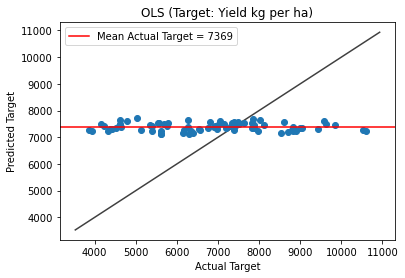

Lasso
MAE on test data: 1461.5175749192288
RMSE on test data: 1788.162703075761
R squared on test data: -0.13052436097708253
MAPE on test data: 25.422766093904563


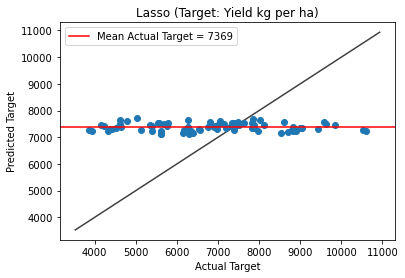

Ridge
MAE on test data: 1460.9686175206978
RMSE on test data: 1787.479343227136
R squared on test data: -0.12966044928044873
MAPE on test data: 25.414458861100243


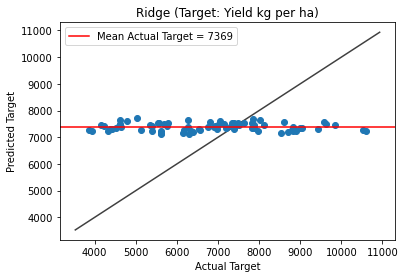

ElasticNet
MAE on test data: 1461.5099481011173
RMSE on test data: 1788.1999975364274
R squared on test data: -0.1305715185829479
MAPE on test data: 25.422639896796984


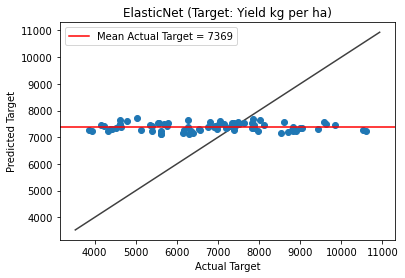

SVR
MAE on test data: 1467.4790914927441
RMSE on test data: 1799.781220529785
R squared on test data: -0.14526316425048003
MAPE on test data: 25.476770454668664


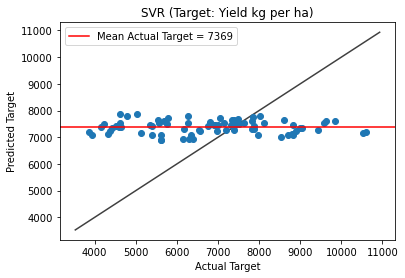

GBR
MAE on test data: 1748.7955369425977
RMSE on test data: 2063.2350823560832
R squared on test data: -0.5050928343234522
MAPE on test data: 28.842419275241348


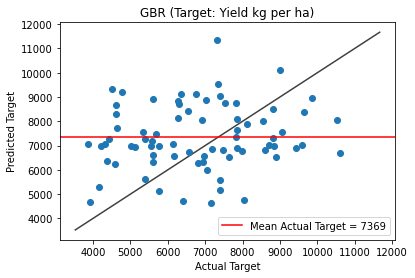

XGBoost
MAE on test data: 1654.2427961357441
RMSE on test data: 1916.8873361074436
R squared on test data: -0.29914922047164927
MAPE on test data: 27.510253764678005


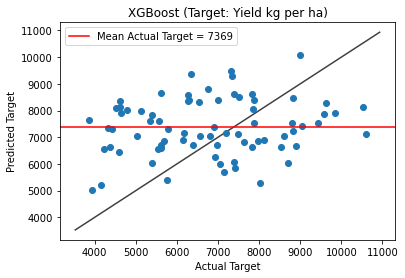

[16:56:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1089.7390192289806
RMSE on test data: 1326.0680679286188
R squared on test data: -0.025941567464968562
MAPE on test data: 16.541072904544514


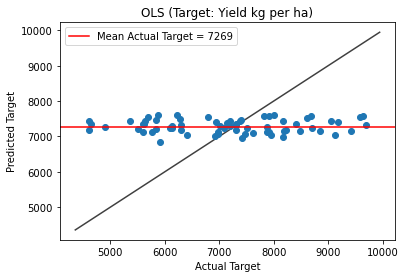

Lasso
MAE on test data: 1089.4414391526245
RMSE on test data: 1325.7680435957645
R squared on test data: -0.025477379206632067
MAPE on test data: 16.534539781435996


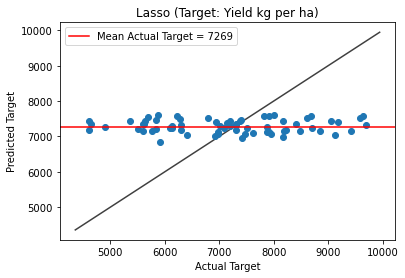

Ridge
MAE on test data: 1088.35439205616
RMSE on test data: 1324.645828553157
R squared on test data: -0.023742054406310942
MAPE on test data: 16.51574002286948


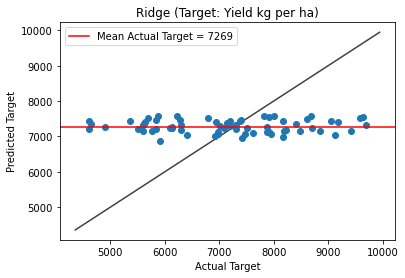

ElasticNet
MAE on test data: 1089.4786279577575
RMSE on test data: 1325.8050818967888
R squared on test data: -0.02553467802387721
MAPE on test data: 16.535356265193155


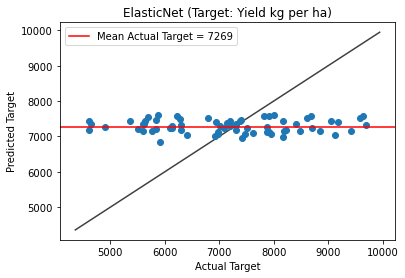

SVR
MAE on test data: 1075.3220133040659
RMSE on test data: 1301.4375401287828
R squared on test data: 0.011816378590157273
MAPE on test data: 16.19366323346492


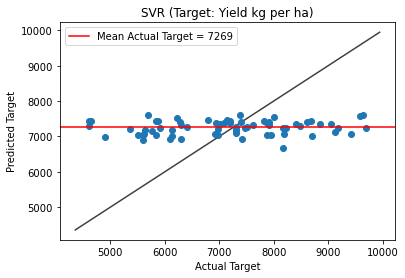

GBR
MAE on test data: 1194.7068266557299
RMSE on test data: 1513.3545841032499
R squared on test data: -0.33620282295093085
MAPE on test data: 18.17302583108938


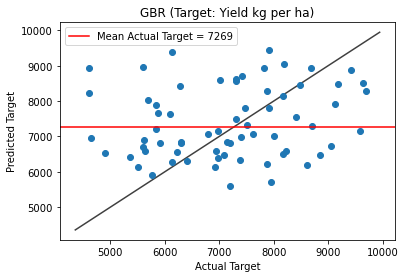

XGBoost
MAE on test data: 1227.6939372793786
RMSE on test data: 1448.6399640982659
R squared on test data: -0.22436784616309713
MAPE on test data: 18.468478518827474


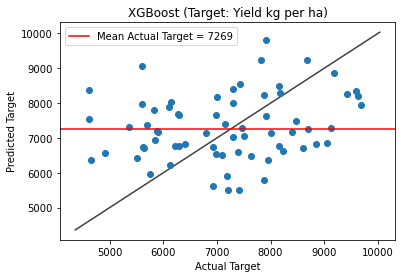

[16:56:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1221.2262083334037
RMSE on test data: 1470.0916583557816
R squared on test data: -0.02578845170997579
MAPE on test data: 17.76618628764189


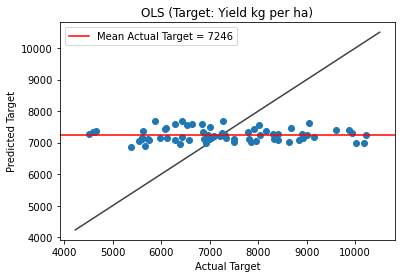

Lasso
MAE on test data: 1220.792739529882
RMSE on test data: 1469.5265834319957
R squared on test data: -0.02500001661446216
MAPE on test data: 17.76019967340943


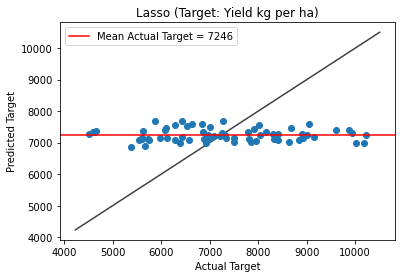

Ridge
MAE on test data: 1219.416696854994
RMSE on test data: 1467.5976226382343
R squared on test data: -0.02231086869292276
MAPE on test data: 17.743360945061408


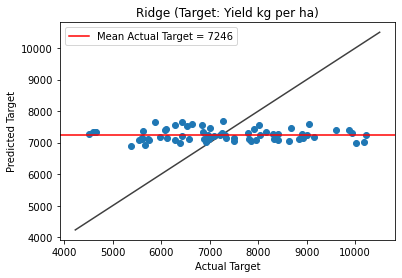

ElasticNet
MAE on test data: 1220.8469358776176
RMSE on test data: 1469.5968711107798
R squared on test data: -0.025098070771075953
MAPE on test data: 17.760948148567188


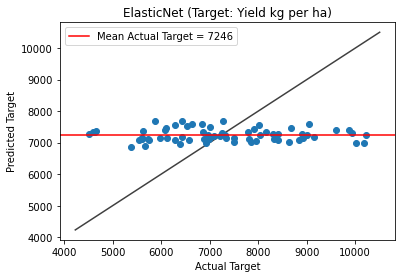

SVR
MAE on test data: 1217.225337372052
RMSE on test data: 1455.369506920762
R squared on test data: -0.005345923916985296
MAPE on test data: 17.929451389629218


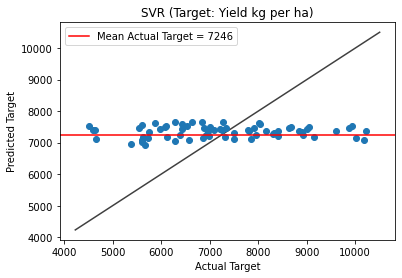

GBR
MAE on test data: 1377.9354360954135
RMSE on test data: 1643.8212007536915
R squared on test data: -0.28256130647461974
MAPE on test data: 19.89296386194144


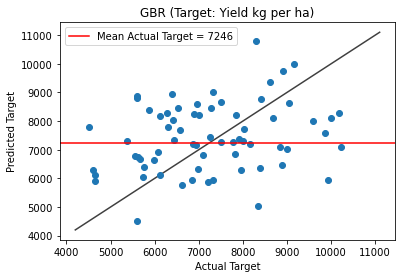

XGBoost
MAE on test data: 1325.1705533657391
RMSE on test data: 1605.4859010874466
R squared on test data: -0.22343801536824603
MAPE on test data: 19.271037637105913


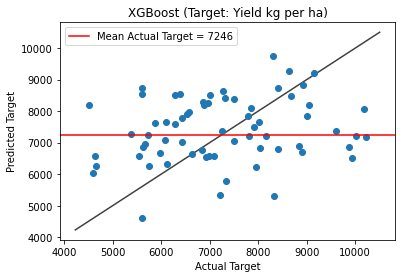

[16:56:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1262.9711759246616
RMSE on test data: 1474.4126983543447
R squared on test data: -0.04692395102147384
MAPE on test data: 17.752582543916724


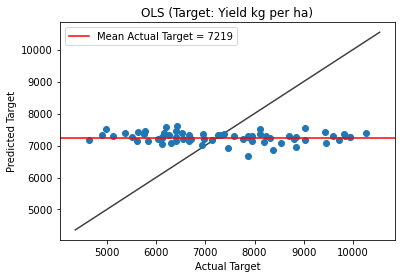

Lasso
MAE on test data: 1262.103390241156
RMSE on test data: 1473.5850072800176
R squared on test data: -0.04574885752308244
MAPE on test data: 17.73943532568138


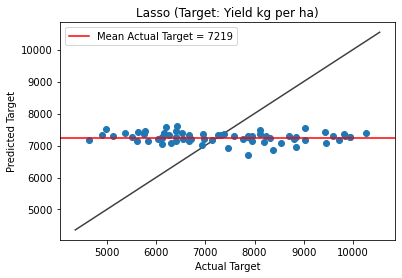

Ridge
MAE on test data: 1260.597690858545
RMSE on test data: 1471.9222950519518
R squared on test data: -0.04339025800856011
MAPE on test data: 17.71243326891121


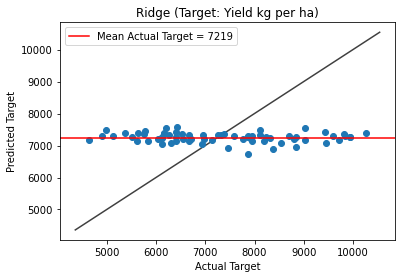

ElasticNet
MAE on test data: 1262.211852778142
RMSE on test data: 1473.6882321202022
R squared on test data: -0.04589537236819585
MAPE on test data: 17.741078572720955


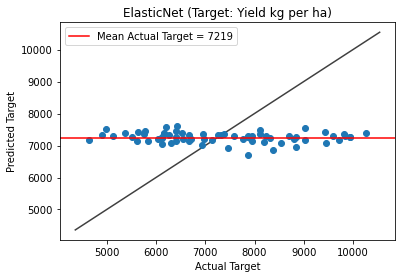

SVR
MAE on test data: 1235.9808971830157
RMSE on test data: 1448.4054855307386
R squared on test data: -0.010316235950412311
MAPE on test data: 17.355875019613595


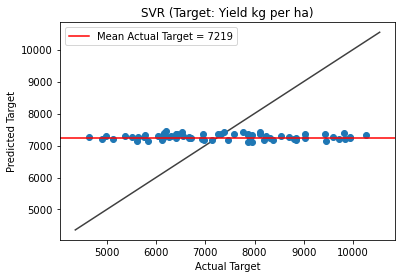

GBR
MAE on test data: 1320.3421627866478
RMSE on test data: 1559.3382063679994
R squared on test data: -0.17100203619438759
MAPE on test data: 18.176065193931247


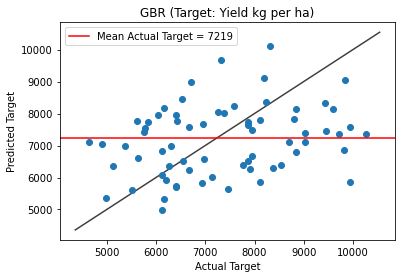

XGBoost
MAE on test data: 1302.8241562871897
RMSE on test data: 1592.701913267859
R squared on test data: -0.22164779054923045
MAPE on test data: 18.187879748114863


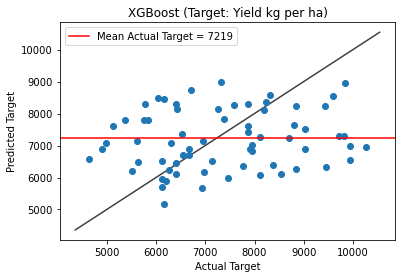

[16:57:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1077.0181668801183
RMSE on test data: 1323.5367138780045
R squared on test data: 0.00459147533669535
MAPE on test data: 16.312870474719418


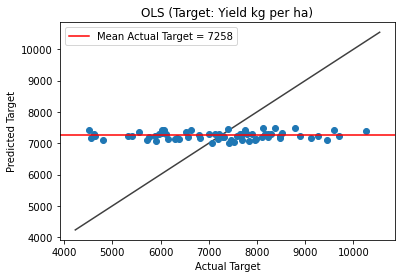

Lasso
MAE on test data: 1077.0588737149506
RMSE on test data: 1323.4407811633057
R squared on test data: 0.004735768698965082
MAPE on test data: 16.314138096687625


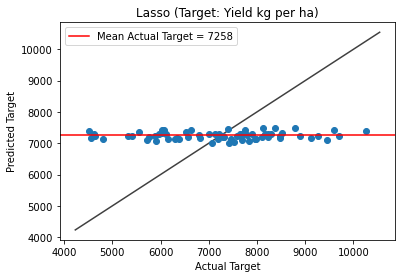

Ridge
MAE on test data: 1076.853123537962
RMSE on test data: 1323.7406840894773
R squared on test data: 0.004284646927771418
MAPE on test data: 16.309974941944915


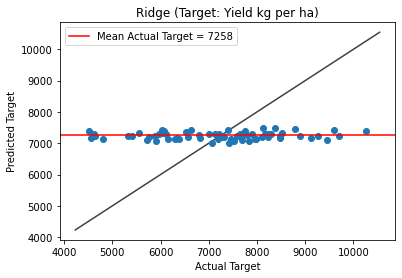

ElasticNet
MAE on test data: 1077.0538001699927
RMSE on test data: 1323.452388535877
R squared on test data: 0.004718310489176369
MAPE on test data: 16.313979872334393


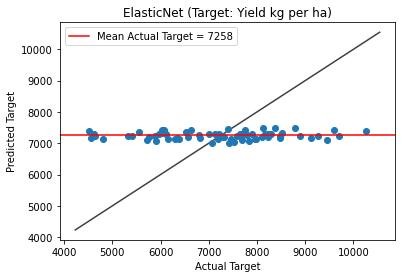

SVR
MAE on test data: 1140.3865698882207
RMSE on test data: 1376.658943115904
R squared on test data: -0.07691664841236001
MAPE on test data: 17.26148022080593


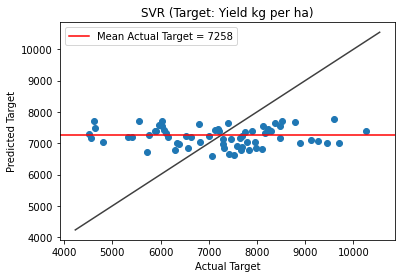

GBR
MAE on test data: 1265.7246062315996
RMSE on test data: 1587.975670101618
R squared on test data: -0.4329038793907527
MAPE on test data: 18.824673587318053


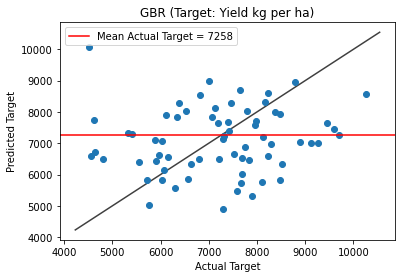

XGBoost
MAE on test data: 1317.8215359260926
RMSE on test data: 1619.2079166094554
R squared on test data: -0.4898227684000993
MAPE on test data: 19.586142485422016


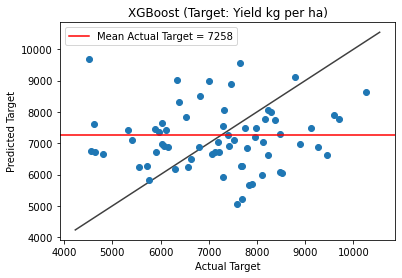

r_2_all_data  r_2_90_percentile  r_2_80_percentile
0     -0.016696          -0.422696          -0.224368
1     -0.064046          -0.162792          -0.223438
2     -0.386463          -0.211371          -0.221648
3     -0.063861          -0.299149          -0.489823

None


In [8]:
#set each equal to a variable and collect
r_0_50 = build_models(df_summer_combined_parents, 0, 50)
r_0_60 = build_models(df_summer_combined_parents, 0, 60)
r_0_70 = build_models(df_summer_combined_parents, 0, 70)
r_0_80 = build_models(df_summer_combined_parents, 0, 80)
r_05_50 = build_models(df_summer_combined_parents, .05, 50)
r_05_60 = build_models(df_summer_combined_parents, .05, 60)
r_05_70 = build_models(df_summer_combined_parents, .05, 70)
r_05_80 = build_models(df_summer_combined_parents, .05, 80)
r_1_50 = build_models(df_summer_combined_parents, .1, 50)
r_1_60 = build_models(df_summer_combined_parents, .1, 60)
r_1_70 = build_models(df_summer_combined_parents, .1, 70)
r_1_80 = build_models(df_summer_combined_parents, .1, 80)

list0 = [r_0_50, r_0_60, r_0_70, r_0_80]
list05 = [r_05_50, r_05_60, r_05_70, r_05_80]
list1 = [r_1_50, r_1_60, r_1_70, r_1_80]

print(display(pd.DataFrame(data = {'r_2_all_data': list0, 'r_2_90_percentile': list05, 'r_2_80_percentile': list1})))

## Model Building Dataset 2: Winter Combined Parents

[19:57:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1465.1166148914508
RMSE on test data: 1894.3669075910332
R squared on test data: 0.025142860551874535
MAPE on test data: 28.340466119379066


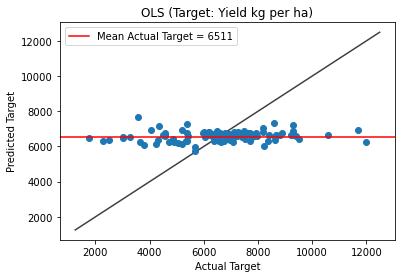

Lasso
MAE on test data: 1465.2187470874874
RMSE on test data: 1894.3343965452818
R squared on test data: 0.025176321179773087
MAPE on test data: 28.346789756517687


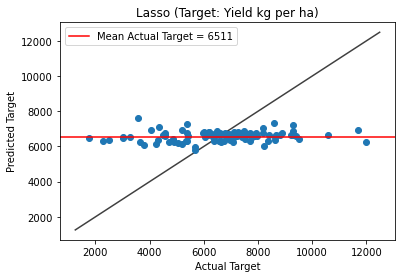

Ridge
MAE on test data: 1465.758332342828
RMSE on test data: 1894.520098985261
R squared on test data: 0.024985187017693034
MAPE on test data: 28.362743960289933


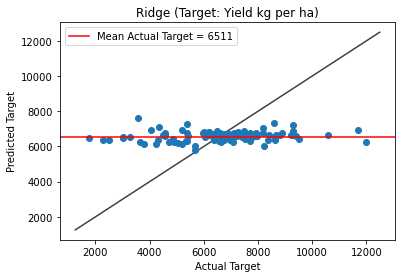

ElasticNet
MAE on test data: 1465.2059920723395
RMSE on test data: 1894.3378758028823
R squared on test data: 0.025172740327507048
MAPE on test data: 28.34599981697627


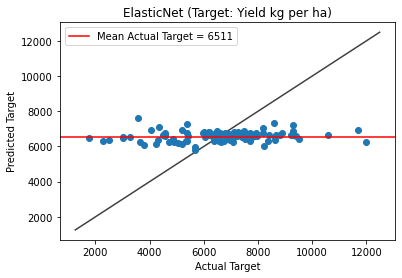

SVR
MAE on test data: 1477.4514094669844
RMSE on test data: 1917.0435622379332
R squared on test data: 0.00166397448758826
MAPE on test data: 29.199086399100878


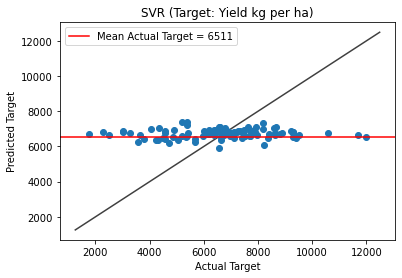

GBR
MAE on test data: 1378.7718073431467
RMSE on test data: 1773.3775269894377
R squared on test data: 0.14569060806631762
MAPE on test data: 23.516355053801615


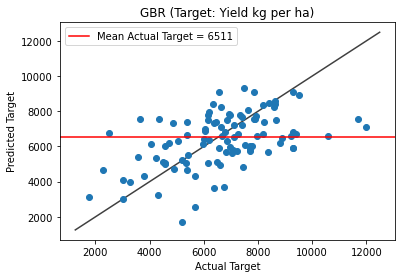

XGBoost
MAE on test data: 1413.1936868565124
RMSE on test data: 1797.3404357829645
R squared on test data: 0.12244676884592531
MAPE on test data: 24.740768294775638


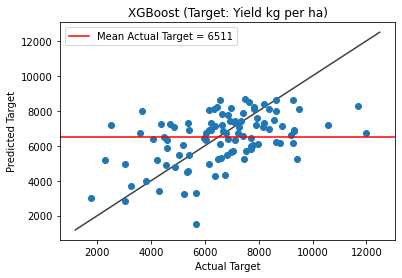

[19:57:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1686.051472239426
RMSE on test data: 2080.915024362552
R squared on test data: -0.04501893025854975
MAPE on test data: 32.186640541175464


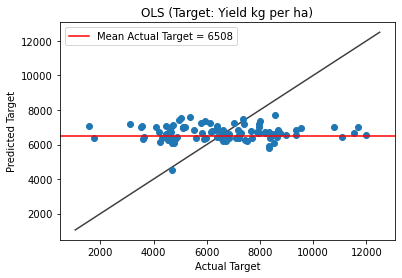

Lasso
MAE on test data: 1684.758087990454
RMSE on test data: 2079.710969504659
R squared on test data: -0.04380994663464044
MAPE on test data: 32.1615363427654


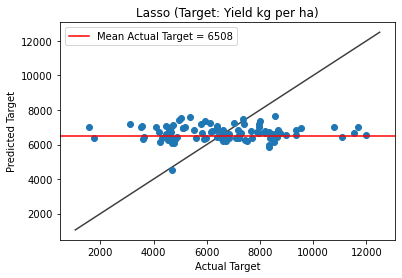

Ridge
MAE on test data: 1680.6065666039513
RMSE on test data: 2076.4619077203797
R squared on test data: -0.0405510766084618
MAPE on test data: 32.08943340978796


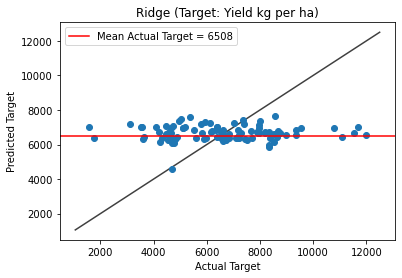

ElasticNet
MAE on test data: 1684.9198378934525
RMSE on test data: 2079.8609736021253
R squared on test data: -0.04396052661230776
MAPE on test data: 32.16467586770027


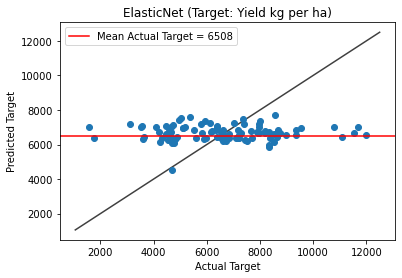

SVR
MAE on test data: 1632.5100062098647
RMSE on test data: 2052.178749239407
R squared on test data: -0.016355959685975696
MAPE on test data: 31.58045667741762


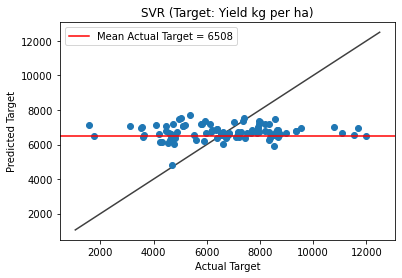

GBR
MAE on test data: 1569.4117861086331
RMSE on test data: 2038.836408817583
R squared on test data: -0.003183145316155711
MAPE on test data: 28.010916544833126


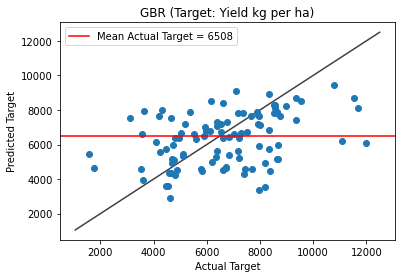

XGBoost
MAE on test data: 1551.4886075985507
RMSE on test data: 1970.3340067839256
R squared on test data: 0.06309582964179983
MAPE on test data: 28.45867079328446


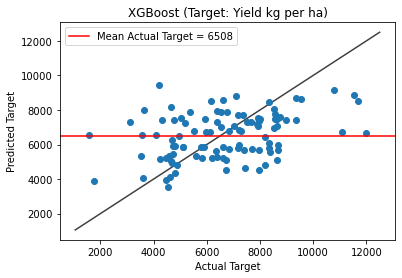

[19:58:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1844.871535623657
RMSE on test data: 2227.7661806567216
R squared on test data: -0.06077460768677234
MAPE on test data: 39.75697055057357


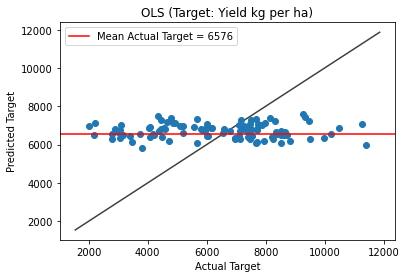

Lasso
MAE on test data: 1845.0755577588172
RMSE on test data: 2227.503918177565
R squared on test data: -0.060524864239452025
MAPE on test data: 39.760228086797675


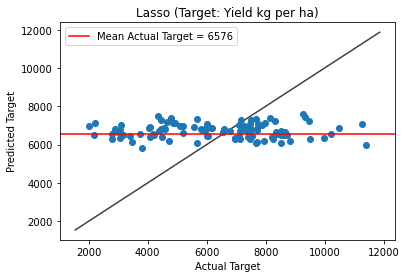

Ridge
MAE on test data: 1843.783185558998
RMSE on test data: 2225.103159603131
R squared on test data: -0.0582400717483742
MAPE on test data: 39.73789605092167


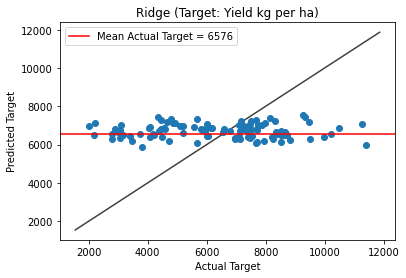

ElasticNet
MAE on test data: 1845.049998425595
RMSE on test data: 2227.5362384170735
R squared on test data: -0.060555640092195384
MAPE on test data: 39.759820127766744


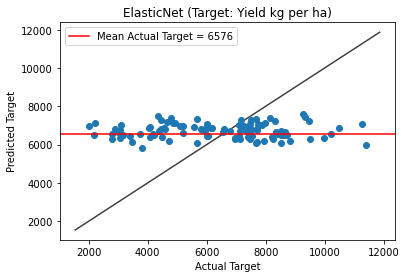

SVR
MAE on test data: 1815.5070219756924
RMSE on test data: 2216.6203985571897
R squared on test data: -0.050186794311944505
MAPE on test data: 39.753932492553936


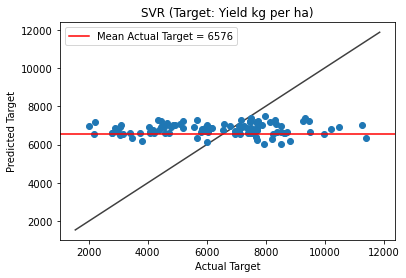

GBR
MAE on test data: 1613.1341113464916
RMSE on test data: 2032.8711033351854
R squared on test data: 0.11670944427957619
MAPE on test data: 31.460376334535905


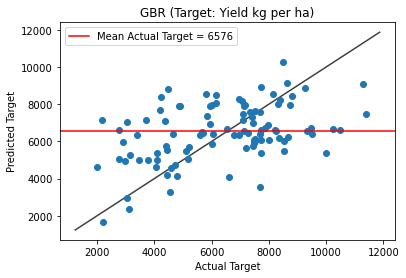

XGBoost
MAE on test data: 1555.4269256883683
RMSE on test data: 1942.2398061683834
R squared on test data: 0.19371310080037096
MAPE on test data: 30.892803621226285


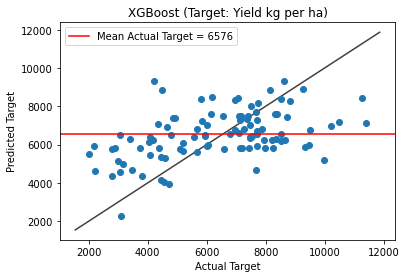

[19:58:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1730.408916121528
RMSE on test data: 2140.5017685584294
R squared on test data: -0.005915336055781983
MAPE on test data: 38.33956257909831


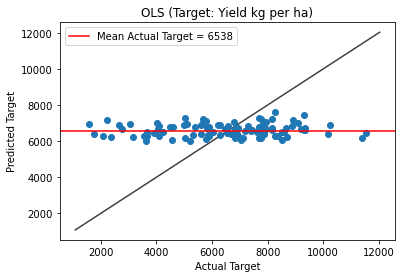

Lasso
MAE on test data: 1730.4438036096356
RMSE on test data: 2140.218384221555
R squared on test data: -0.0056490043154051595
MAPE on test data: 38.33910886961234


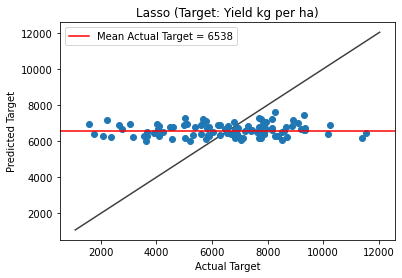

Ridge
MAE on test data: 1730.1316421049921
RMSE on test data: 2139.2465455701386
R squared on test data: -0.004735913684295268
MAPE on test data: 38.33816428013582


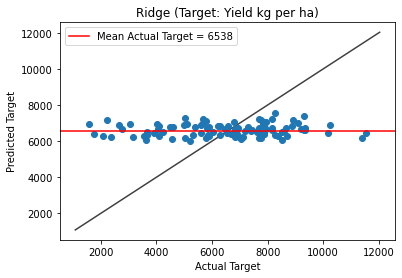

ElasticNet
MAE on test data: 1730.4394654078342
RMSE on test data: 2140.2534582304065
R squared on test data: -0.005681965840602654
MAPE on test data: 38.33916627524314


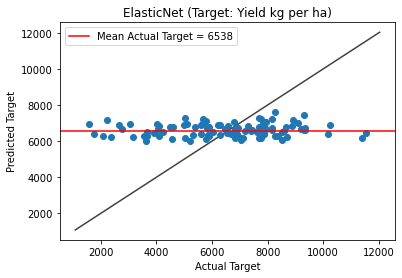

SVR
MAE on test data: 1715.3477924148726
RMSE on test data: 2145.9185591671776
R squared on test data: -0.011012951279123717
MAPE on test data: 38.59095935870968


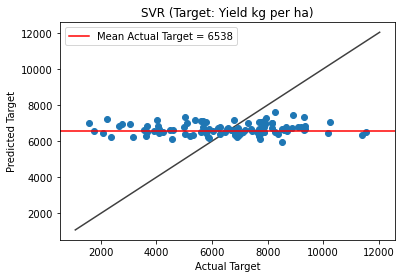

GBR
MAE on test data: 1504.9668708814017
RMSE on test data: 1963.132769647259
R squared on test data: 0.15388461377110096
MAPE on test data: 30.624276993265298


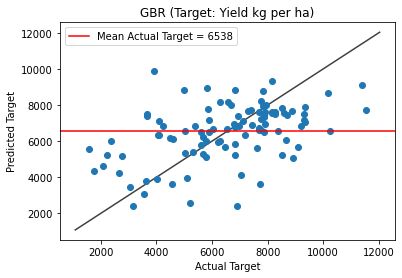

XGBoost
MAE on test data: 1488.8885566065596
RMSE on test data: 1911.4647991355303
R squared on test data: 0.19783657430019796
MAPE on test data: 30.646110035787576


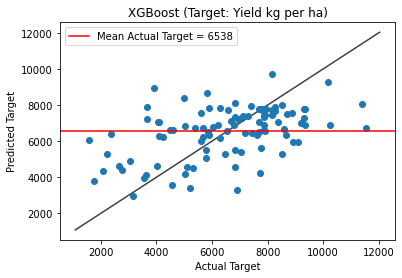

[19:58:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1518.2552839499351
RMSE on test data: 1839.1739226075115
R squared on test data: -0.10838748883181593
MAPE on test data: 30.4400246608002


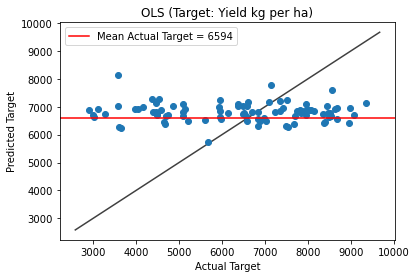

Lasso
MAE on test data: 1518.2257539212703
RMSE on test data: 1839.1228014278256
R squared on test data: -0.10832587281192807
MAPE on test data: 30.43938265581997


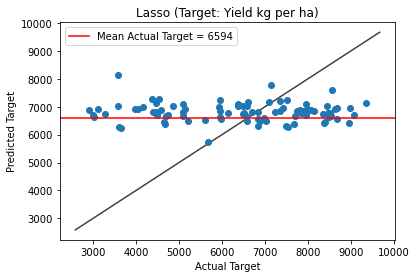

Ridge
MAE on test data: 1516.1175049215265
RMSE on test data: 1835.2939371540022
R squared on test data: -0.1037158359669248
MAPE on test data: 30.392249926318687


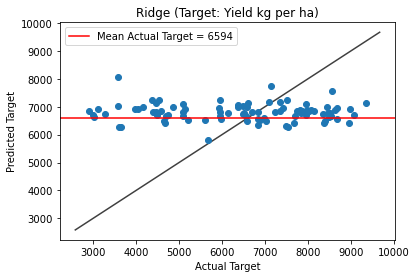

ElasticNet
MAE on test data: 1518.206945186716
RMSE on test data: 1839.0898939662943
R squared on test data: -0.10828621057219445
MAPE on test data: 30.438971777887268


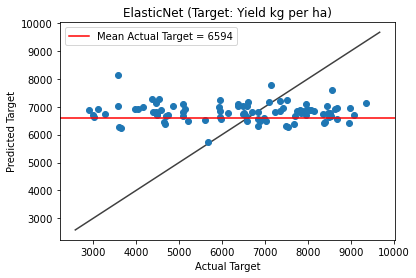

SVR
MAE on test data: 1505.5013928886312
RMSE on test data: 1831.4003031232126
R squared on test data: -0.09903766769324807
MAPE on test data: 30.419838950834


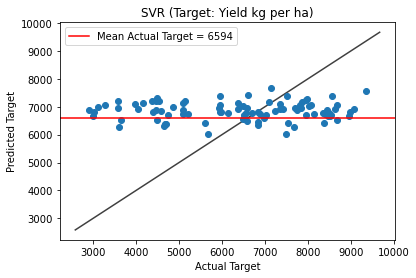

GBR
MAE on test data: 1211.5499704271058
RMSE on test data: 1674.4330414935991
R squared on test data: 0.08128335555924104
MAPE on test data: 22.347250449589005


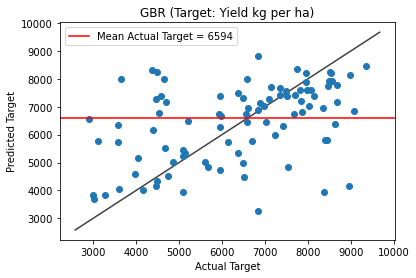

XGBoost
MAE on test data: 1281.3297994338716
RMSE on test data: 1658.9686475111116
R squared on test data: 0.09817479150531128
MAPE on test data: 24.103440033708836


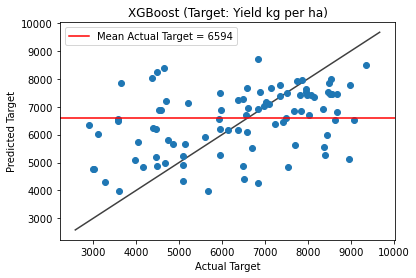

[19:59:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1478.0661526824183
RMSE on test data: 1757.4102470810083
R squared on test data: -0.0672436286031477
MAPE on test data: 26.237599746527078


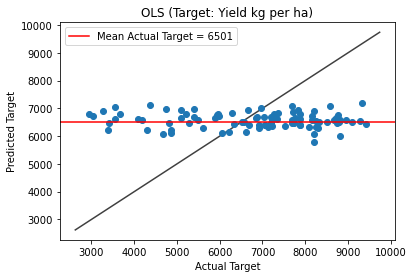

Lasso
MAE on test data: 1477.352977843808
RMSE on test data: 1756.4509687175614
R squared on test data: -0.06607884160120059
MAPE on test data: 26.22614863010377


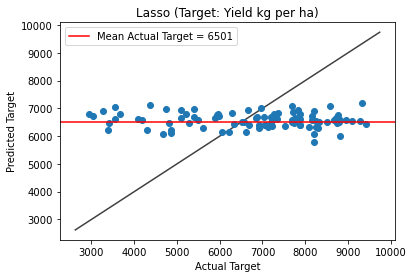

Ridge
MAE on test data: 1475.1200863491647
RMSE on test data: 1754.0403968685243
R squared on test data: -0.06315465386251051
MAPE on test data: 26.198389338330898


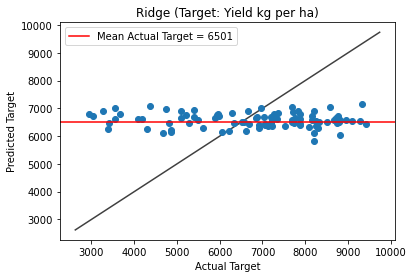

ElasticNet
MAE on test data: 1477.442024750171
RMSE on test data: 1756.5705225830675
R squared on test data: -0.06622397310367689
MAPE on test data: 26.227578172872263


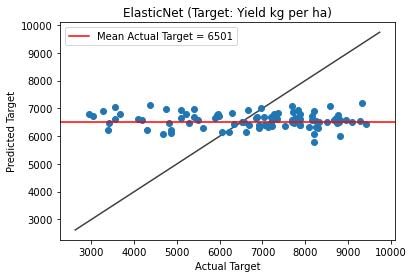

SVR
MAE on test data: 1478.5571629051426
RMSE on test data: 1775.7290100823004
R squared on test data: -0.08960889942250239
MAPE on test data: 26.43242147586657


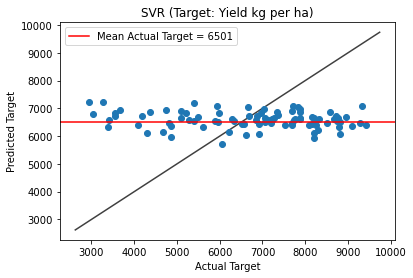

GBR
MAE on test data: 1397.3747335642327
RMSE on test data: 1898.553810002225
R squared on test data: -0.24555549906231544
MAPE on test data: 22.58748784358168


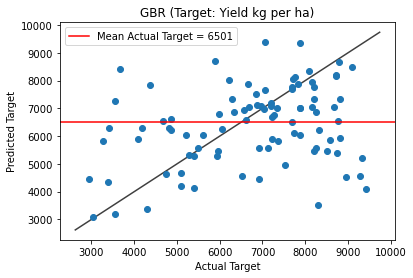

XGBoost
MAE on test data: 1261.9011985154468
RMSE on test data: 1724.3852599766162
R squared on test data: -0.02750954700645547
MAPE on test data: 20.27991798408704


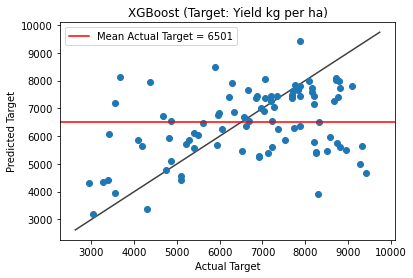

[19:59:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1390.4283177600778
RMSE on test data: 1651.3415075131743
R squared on test data: -0.0011519755063327253
MAPE on test data: 25.49264220911709


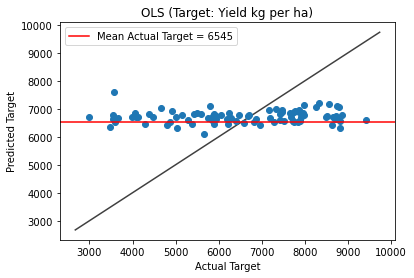

Lasso
MAE on test data: 1391.2967685478866
RMSE on test data: 1651.5467507481176
R squared on test data: -0.0014008549035953166
MAPE on test data: 25.504926785511344


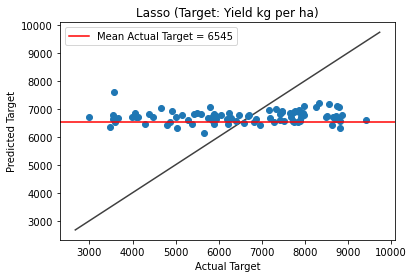

Ridge
MAE on test data: 1392.0854083841061
RMSE on test data: 1651.3198795243884
R squared on test data: -0.0011257510557216577
MAPE on test data: 25.514157509882434


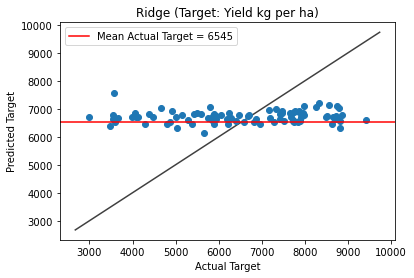

ElasticNet
MAE on test data: 1391.1882145171087
RMSE on test data: 1651.5206803587714
R squared on test data: -0.00136924005029182
MAPE on test data: 25.503391744395437


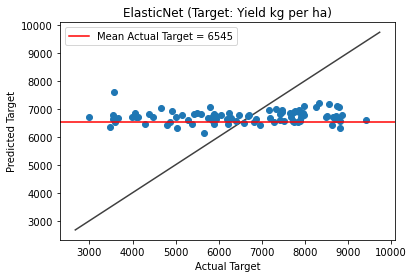

SVR
MAE on test data: 1392.555371420648
RMSE on test data: 1647.3867650887844
R squared on test data: 0.0036375331174649528
MAPE on test data: 25.562354416962783


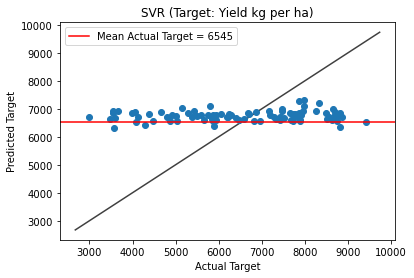

GBR
MAE on test data: 1212.4387715392693
RMSE on test data: 1638.5340440450727
R squared on test data: 0.014317258519728093
MAPE on test data: 20.205145996687392


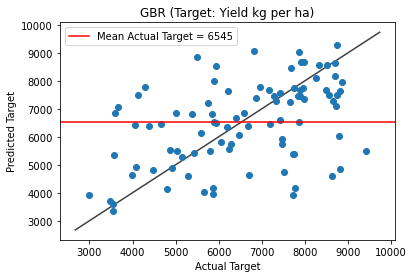

XGBoost
MAE on test data: 1251.8189196384606
RMSE on test data: 1673.1187770187696
R squared on test data: -0.02773171920780082
MAPE on test data: 21.916629818848886


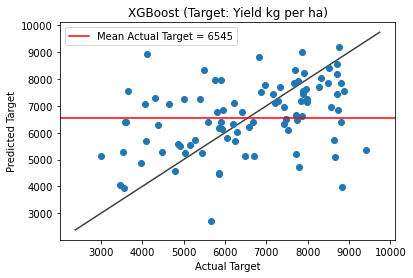

[20:00:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1377.7091868870796
RMSE on test data: 1663.1593324442135
R squared on test data: 0.01191160065422614
MAPE on test data: 25.01643990092367


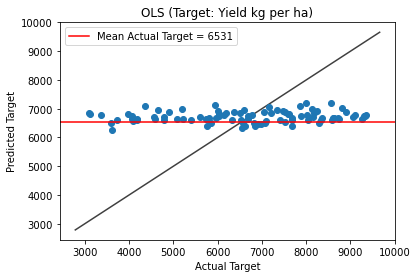

Lasso
MAE on test data: 1377.701618357638
RMSE on test data: 1663.2216971441317
R squared on test data: 0.011837497120481655
MAPE on test data: 25.014905832722413


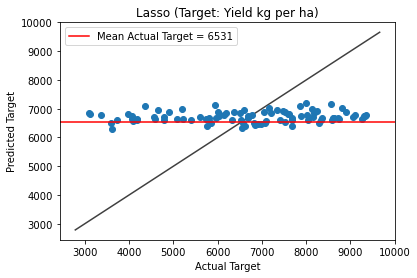

Ridge
MAE on test data: 1377.6117147957157
RMSE on test data: 1663.2152455927485
R squared on test data: 0.011845163168620276
MAPE on test data: 25.009553123111296


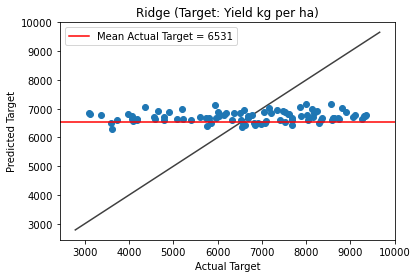

ElasticNet
MAE on test data: 1377.7025536990059
RMSE on test data: 1663.2136577778747
R squared on test data: 0.011847049883166205
MAPE on test data: 25.015097609758975


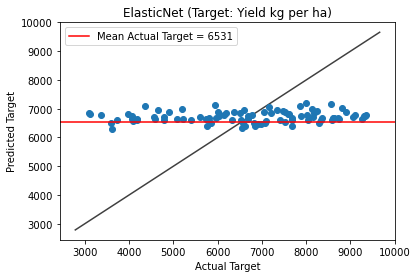

SVR
MAE on test data: 1368.82162818892
RMSE on test data: 1677.8715370022896
R squared on test data: -0.005646855575714538
MAPE on test data: 25.162437659700444


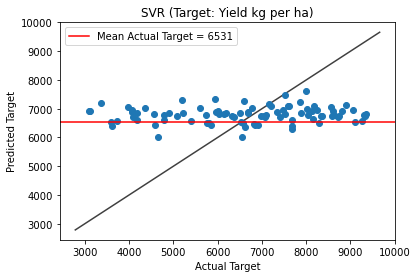

GBR
MAE on test data: 1200.4191518922248
RMSE on test data: 1597.1477909256562
R squared on test data: 0.08879037905440512
MAPE on test data: 20.6804845117071


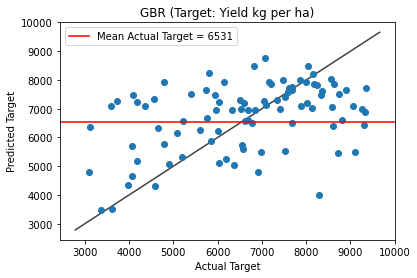

XGBoost
MAE on test data: 1184.5750908778382
RMSE on test data: 1491.6207955960783
R squared on test data: 0.20522363190648185
MAPE on test data: 20.165215675536743


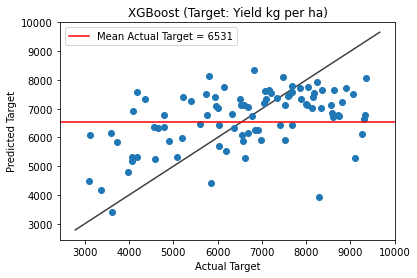

[20:00:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1251.4503474503538
RMSE on test data: 1521.2996840085264
R squared on test data: -0.057376056119610386
MAPE on test data: 22.17596535038668


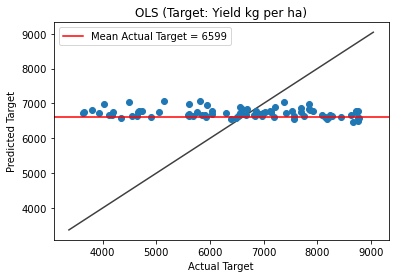

Lasso
MAE on test data: 1251.3164850764463
RMSE on test data: 1520.873817603725
R squared on test data: -0.05678414393218989
MAPE on test data: 22.173721107755135


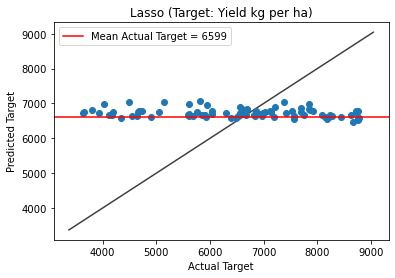

Ridge
MAE on test data: 1250.7876224014947
RMSE on test data: 1520.115385484809
R squared on test data: -0.05573040866270662
MAPE on test data: 22.166577294659483


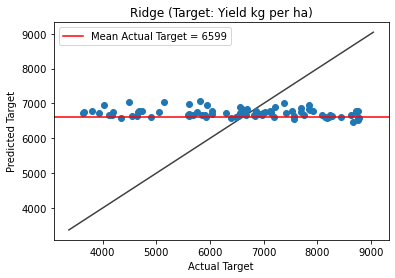

ElasticNet
MAE on test data: 1251.3331952221968
RMSE on test data: 1520.926809687708
R squared on test data: -0.05685778866075153
MAPE on test data: 22.174001508743416


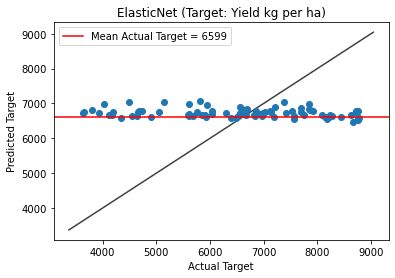

SVR
MAE on test data: 1268.6042953293268
RMSE on test data: 1556.0053459691253
R squared on test data: -0.10617054809489712
MAPE on test data: 22.54256526208553


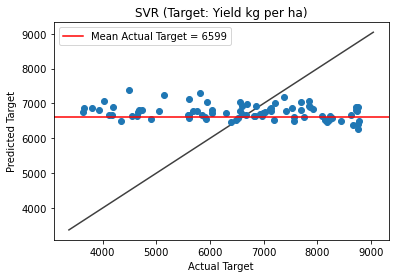

GBR
MAE on test data: 1256.3914599974673
RMSE on test data: 1668.943297491751
R squared on test data: -0.27257411482728977
MAPE on test data: 22.037761072960663


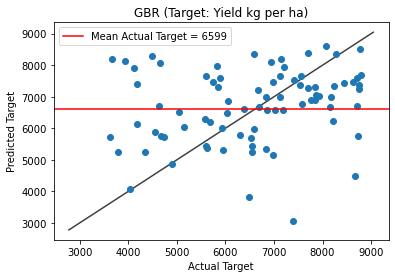

XGBoost
MAE on test data: 1195.9118820012613
RMSE on test data: 1594.6073880543915
R squared on test data: -0.16173604794651797
MAPE on test data: 21.22458401434311


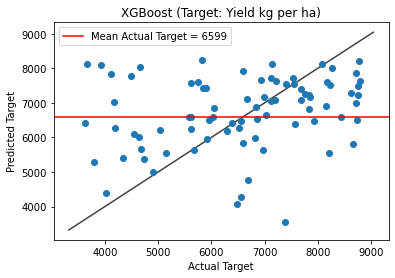

[20:00:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1315.9867348502119
RMSE on test data: 1543.5595430225114
R squared on test data: -0.13636579637164492
MAPE on test data: 23.400838384866546


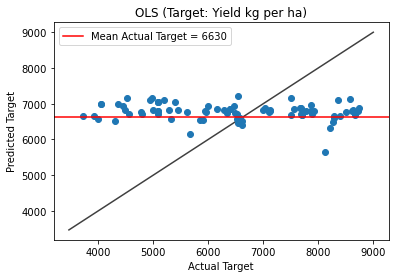

Lasso
MAE on test data: 1315.6993169235182
RMSE on test data: 1542.9413107889109
R squared on test data: -0.13545569572008453
MAPE on test data: 23.394819655367534


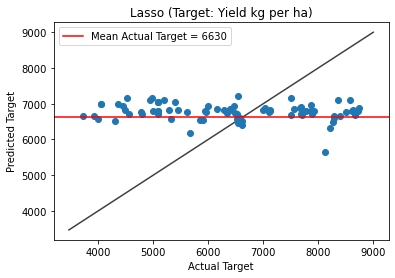

Ridge
MAE on test data: 1313.5113208857272
RMSE on test data: 1539.423596364264
R squared on test data: -0.13028420189647427
MAPE on test data: 23.359512744260115


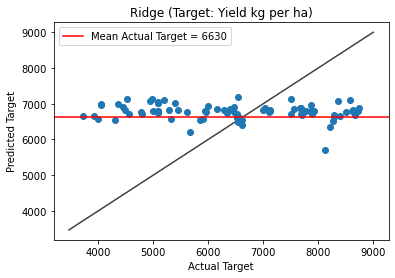

ElasticNet
MAE on test data: 1315.7352277205619
RMSE on test data: 1543.0182176556168
R squared on test data: -0.13556889058438948
MAPE on test data: 23.395572255261182


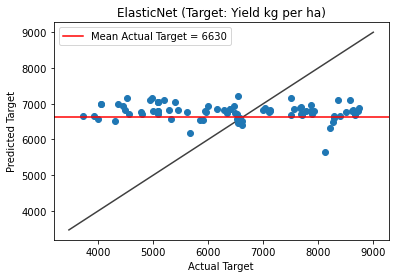

SVR
MAE on test data: 1323.6518812252505
RMSE on test data: 1563.1829643156366
R squared on test data: -0.16544291488126395
MAPE on test data: 23.615205267745836


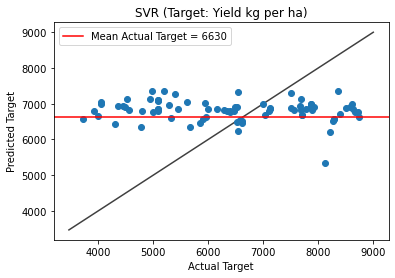

GBR
MAE on test data: 1180.6390356218194
RMSE on test data: 1502.729649321336
R squared on test data: -0.0770431170117003
MAPE on test data: 20.24735099596625


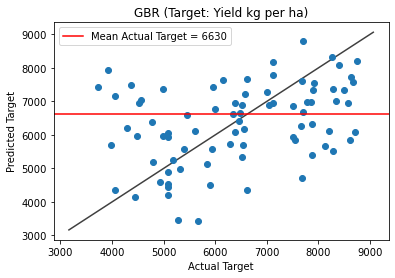

XGBoost
MAE on test data: 1122.3109477747626
RMSE on test data: 1422.235103379328
R squared on test data: 0.03525137918729415
MAPE on test data: 19.21434394328584


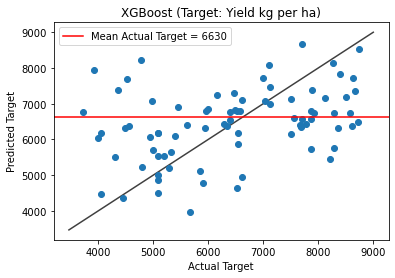

[20:01:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1161.238638616062
RMSE on test data: 1392.9725794410804
R squared on test data: -0.06676762429946015
MAPE on test data: 20.398420964222886


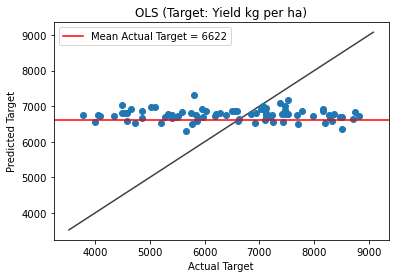

Lasso
MAE on test data: 1161.1940603622809
RMSE on test data: 1392.7447246117588
R squared on test data: -0.06641866082570846
MAPE on test data: 20.399265880473557


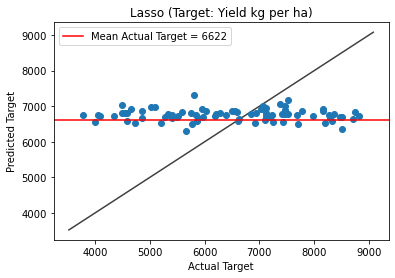

Ridge
MAE on test data: 1161.2853370551315
RMSE on test data: 1392.045745488401
R squared on test data: -0.06534851879776049
MAPE on test data: 20.404571717542076


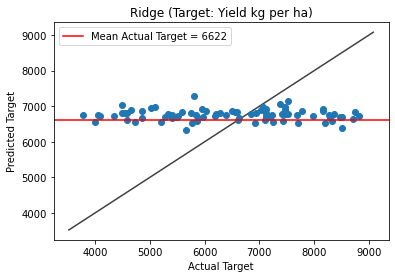

ElasticNet
MAE on test data: 1161.2031438550136
RMSE on test data: 1392.7872170403964
R squared on test data: -0.06648373435901944
MAPE on test data: 20.39911640682289


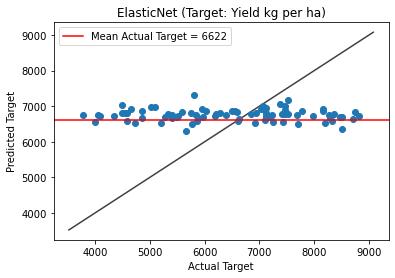

SVR
MAE on test data: 1156.3301508499885
RMSE on test data: 1407.6605168524882
R squared on test data: -0.0893828914176491
MAPE on test data: 20.500143571712314


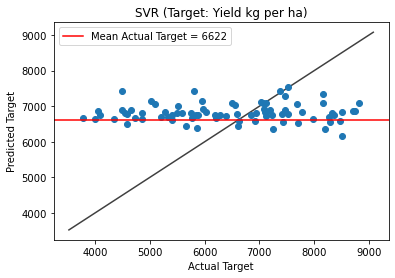

GBR
MAE on test data: 1275.1047292241742
RMSE on test data: 1609.2110838618396
R squared on test data: -0.42367455219290284
MAPE on test data: 21.555840717525083


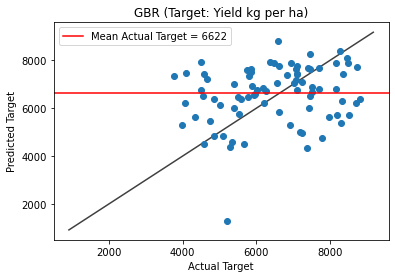

XGBoost
MAE on test data: 1114.6774409631512
RMSE on test data: 1427.9594702556506
R squared on test data: -0.12102798375502677
MAPE on test data: 18.964690281069647


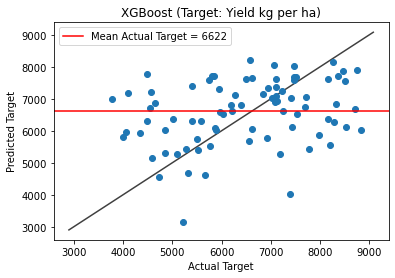

[20:01:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1117.1348859793743
RMSE on test data: 1380.1516465365537
R squared on test data: -0.04351658453080143
MAPE on test data: 18.452797185410684


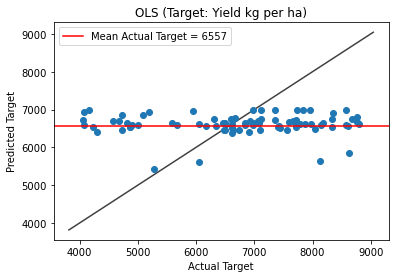

Lasso
MAE on test data: 1116.960071947116
RMSE on test data: 1380.1828604487202
R squared on test data: -0.04356378601540212
MAPE on test data: 18.450582332200327


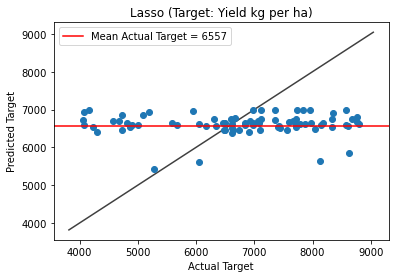

Ridge
MAE on test data: 1115.0051142414977
RMSE on test data: 1377.2833930719144
R squared on test data: -0.03918378538775125
MAPE on test data: 18.42571961436348


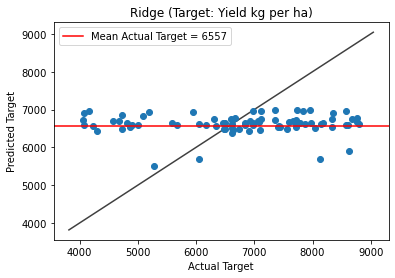

ElasticNet
MAE on test data: 1116.9818797449968
RMSE on test data: 1380.1783816965933
R squared on test data: -0.043557013208585404
MAPE on test data: 18.45085887774724


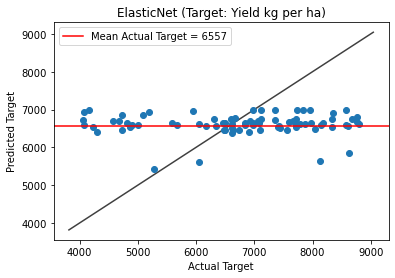

SVR
MAE on test data: 1150.4104227280022
RMSE on test data: 1406.9267833140543
R squared on test data: -0.08439806625256785
MAPE on test data: 18.92080080078972


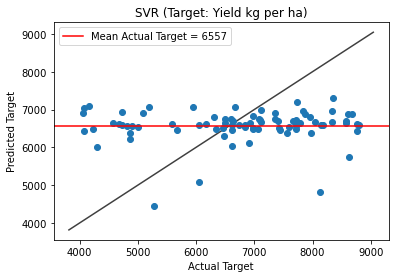

GBR
MAE on test data: 1269.794905540016
RMSE on test data: 1569.006162208964
R squared on test data: -0.3486369006991519
MAPE on test data: 19.321563643333477


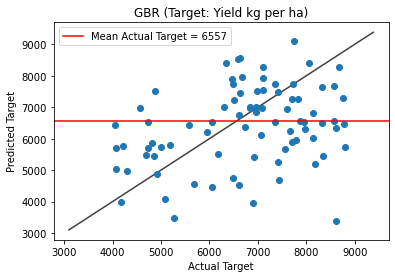

XGBoost
MAE on test data: 1150.9722626511298
RMSE on test data: 1388.060042123104
R squared on test data: -0.05550973888265753
MAPE on test data: 17.705475064747965


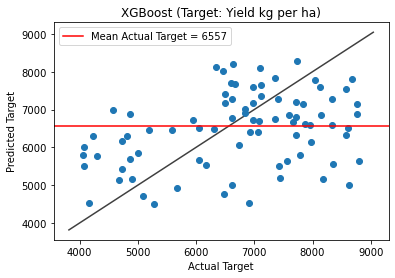

r_2_all_data  r_2_90_percentile  r_2_80_percentile
0      0.122447           0.098175          -0.161736
1      0.063096          -0.027510           0.035251
2      0.193713          -0.027732          -0.121028
3      0.197837           0.205224          -0.055510

None


In [6]:
r_0_50 = build_models(df_winter_combined_parents, 0, 10)
r_0_60 = build_models(df_winter_combined_parents, 0, 20)
r_0_70 = build_models(df_winter_combined_parents, 0, 30)
r_0_80 = build_models(df_winter_combined_parents, 0, 40)
r_05_50 = build_models(df_winter_combined_parents, .05, 50)
r_05_60 = build_models(df_winter_combined_parents, .05, 60)
r_05_70 = build_models(df_winter_combined_parents, .05, 70)
r_05_80 = build_models(df_winter_combined_parents, .05, 80)
r_1_50 = build_models(df_winter_combined_parents, .1, 50)
r_1_60 = build_models(df_winter_combined_parents, .1, 60)
r_1_70 = build_models(df_winter_combined_parents, .1, 70)
r_1_80 = build_models(df_winter_combined_parents, .1, 80)

list0 = [r_0_50, r_0_60, r_0_70, r_0_80]
list05 = [r_05_50, r_05_60, r_05_70, r_05_80]
list1 = [r_1_50, r_1_60, r_1_70, r_1_80]

print(display(pd.DataFrame(data = {'r_2_all_data': list0, 'r_2_90_percentile': list05, 'r_2_80_percentile': list1})))

## Model Building Dataset 3: Summer Acceptable DY/WY Ratio Combined Parents

[17:04:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1521.1837469327916
RMSE on test data: 1988.6719370177834
R squared on test data: -0.01618970679931553
MAPE on test data: 23.830600335737984


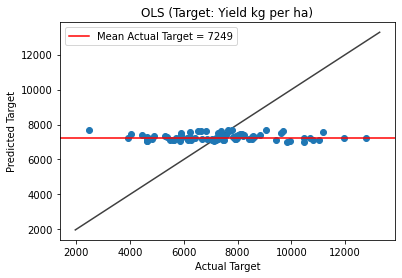

Lasso
MAE on test data: 1520.995385705875
RMSE on test data: 1987.8573729108273
R squared on test data: -0.015357410510297154
MAPE on test data: 23.82801652752861


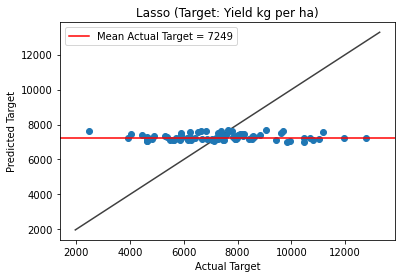

Ridge
MAE on test data: 1520.5078700946135
RMSE on test data: 1987.0290034961413
R squared on test data: -0.014511358084405401
MAPE on test data: 23.814752713796242


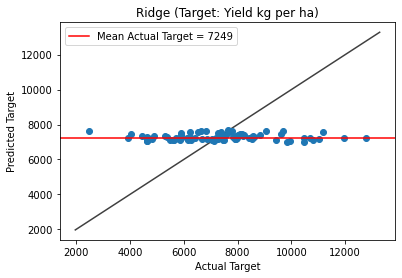

ElasticNet
MAE on test data: 1521.0189557942165
RMSE on test data: 1987.9585900574307
R squared on test data: -0.015460812492473552
MAPE on test data: 23.828339755340178


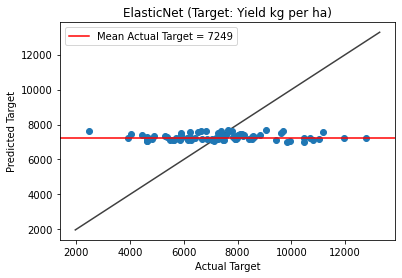

SVR
MAE on test data: 1552.4738569797742
RMSE on test data: 1964.3792454294805
R squared on test data: 0.00848525988635862
MAPE on test data: 24.425199380349348


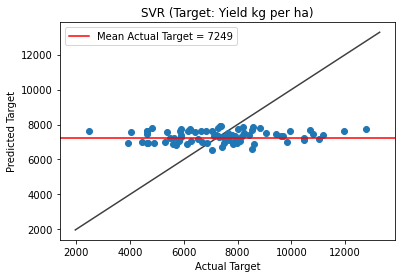

GBR
MAE on test data: 1743.679211209427
RMSE on test data: 2316.064808746578
R squared on test data: -0.37831955106389925
MAPE on test data: 25.39906081525555


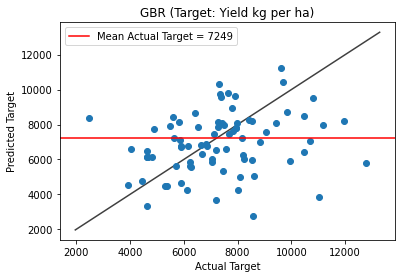

XGBoost
MAE on test data: 1527.512097209307
RMSE on test data: 2032.7664635736437
R squared on test data: -0.06175294747454263
MAPE on test data: 22.428556082095437


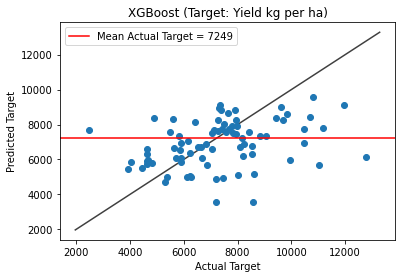

[17:04:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1769.403284622153
RMSE on test data: 2199.7231541064793
R squared on test data: -0.07337152284900617
MAPE on test data: 35.292018911535976


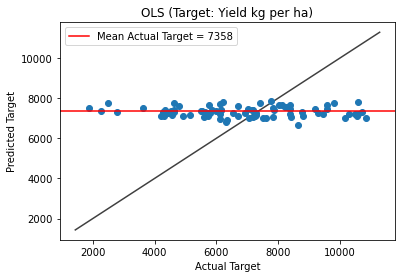

Lasso
MAE on test data: 1768.7581174641368
RMSE on test data: 2199.0293414860334
R squared on test data: -0.07269452741703608
MAPE on test data: 35.27862076318767


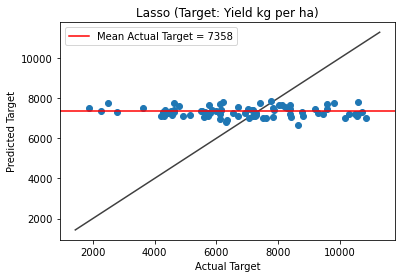

Ridge
MAE on test data: 1768.6578092974337
RMSE on test data: 2198.6088384266145
R squared on test data: -0.07228432079115521
MAPE on test data: 35.28174200051311


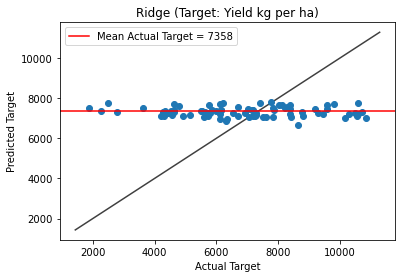

ElasticNet
MAE on test data: 1768.8387563291217
RMSE on test data: 2199.1157397957327
R squared on test data: -0.072778819893621
MAPE on test data: 35.280295391991906


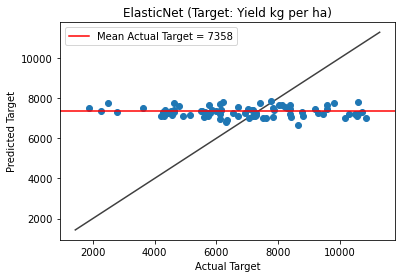

SVR
MAE on test data: 1791.1773010369332
RMSE on test data: 2234.1439373040926
R squared on test data: -0.10722610323053305
MAPE on test data: 35.76497584771023


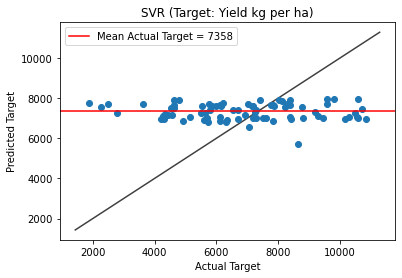

GBR
MAE on test data: 1781.108220134846
RMSE on test data: 2128.6903938260207
R squared on test data: -0.005168840446799772
MAPE on test data: 32.42460238867852


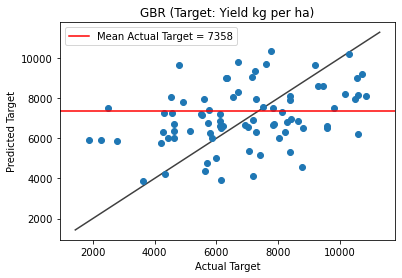

XGBoost
MAE on test data: 1847.0881279560854
RMSE on test data: 2139.2971799981515
R squared on test data: -0.015210858013110506
MAPE on test data: 34.23599541263162


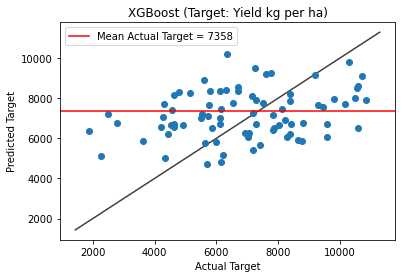

[17:05:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1661.6031771333583
RMSE on test data: 2073.0242821144398
R squared on test data: -0.03486923904246764
MAPE on test data: 24.667710743969415


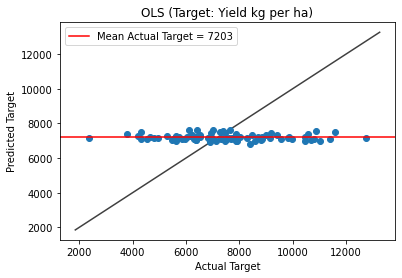

Lasso
MAE on test data: 1660.6559180680597
RMSE on test data: 2072.3076040407964
R squared on test data: -0.034153820611751984
MAPE on test data: 24.652082617827666


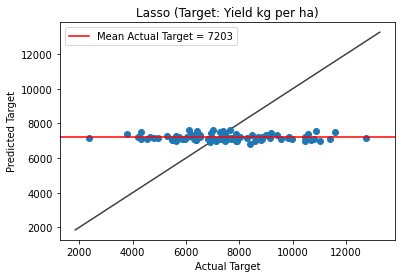

Ridge
MAE on test data: 1659.5857167370536
RMSE on test data: 2071.5154137654367
R squared on test data: -0.03336331054481878
MAPE on test data: 24.641318302746157


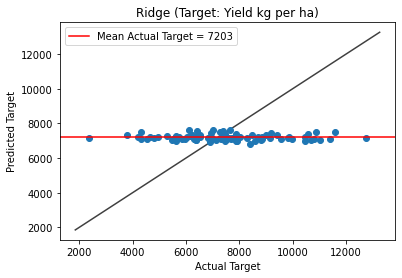

ElasticNet
MAE on test data: 1660.774343984363
RMSE on test data: 2072.396927093702
R squared on test data: -0.03424297317486791
MAPE on test data: 24.654036561798286


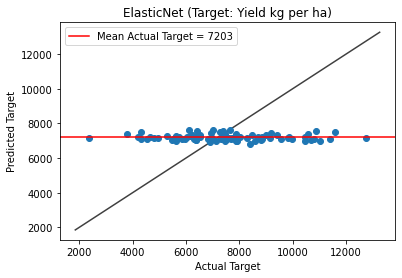

SVR
MAE on test data: 1633.6277908941343
RMSE on test data: 2053.4930481478286
R squared on test data: -0.01546082468764931
MAPE on test data: 24.371355661074716


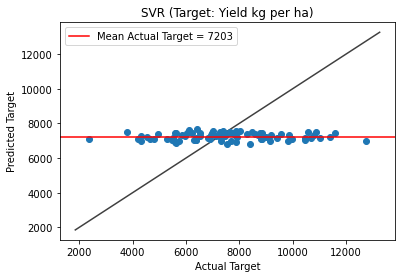

GBR
MAE on test data: 1821.8805508622638
RMSE on test data: 2302.212765163078
R squared on test data: -0.27634362894673736
MAPE on test data: 27.01032924108079


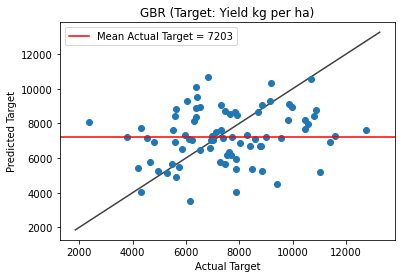

XGBoost
MAE on test data: 1744.3449751639935
RMSE on test data: 2220.369451383464
R squared on test data: -0.18720901750406949
MAPE on test data: 26.403111342758827


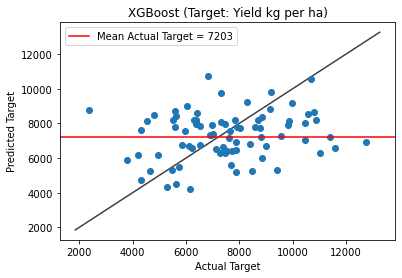

[17:05:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1782.776487219992
RMSE on test data: 2198.9874037313703
R squared on test data: 0.0026606687715420296
MAPE on test data: 31.690371442244043


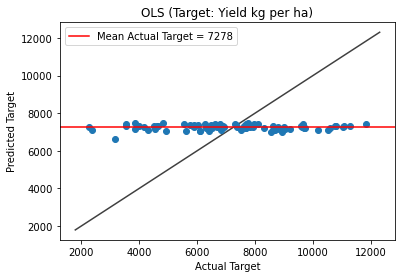

Lasso
MAE on test data: 1782.635820746246
RMSE on test data: 2198.8823696601703
R squared on test data: 0.002755941812543239
MAPE on test data: 31.692498932481072


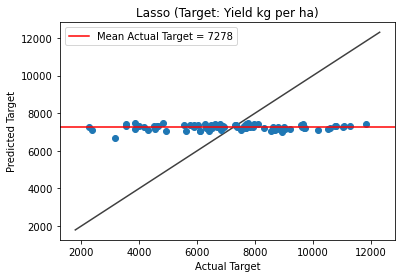

Ridge
MAE on test data: 1782.725066255552
RMSE on test data: 2199.057109615643
R squared on test data: 0.0025974382848625854
MAPE on test data: 31.69380018313942


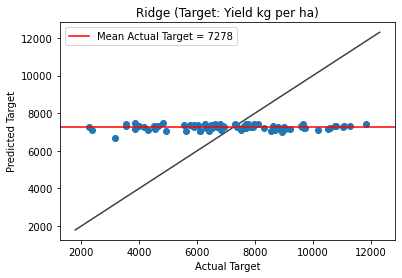

ElasticNet
MAE on test data: 1782.6534025028327
RMSE on test data: 2198.8951735525466
R squared on test data: 0.0027443280555319305
MAPE on test data: 31.692232962678546


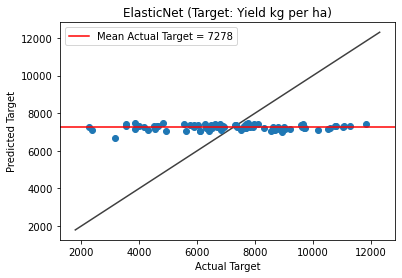

SVR
MAE on test data: 1789.191955139154
RMSE on test data: 2213.47116762179
R squared on test data: -0.010520670558249234
MAPE on test data: 31.8352238885867


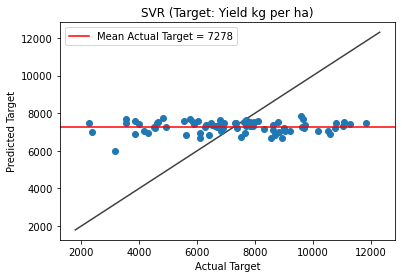

GBR
MAE on test data: 1743.9372116452291
RMSE on test data: 2211.8747377172936
R squared on test data: -0.009063553171814398
MAPE on test data: 30.007486519035055


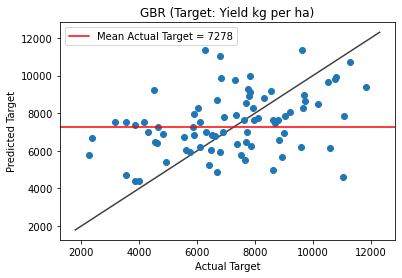

XGBoost
MAE on test data: 1787.0929937641238
RMSE on test data: 2213.2972228891954
R squared on test data: -0.010361854085914946
MAPE on test data: 31.61423520109348


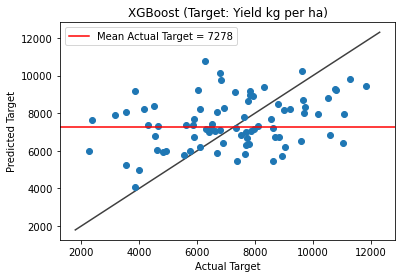

[17:05:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1562.4108576340525
RMSE on test data: 1887.0149236225984
R squared on test data: -0.010070452546455
MAPE on test data: 23.656499474284693


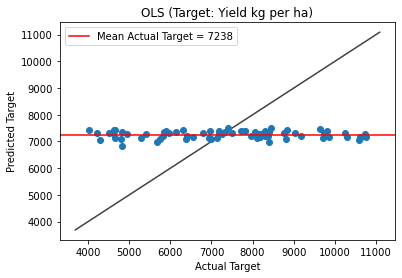

Lasso
MAE on test data: 1562.4953651223307
RMSE on test data: 1886.855459623569
R squared on test data: -0.009899745822341321
MAPE on test data: 23.656693731489252


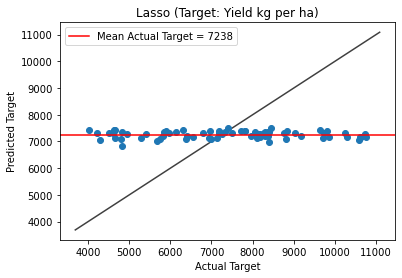

Ridge
MAE on test data: 1561.9882162052297
RMSE on test data: 1886.4520890683382
R squared on test data: -0.009468000744937255
MAPE on test data: 23.647005027197128


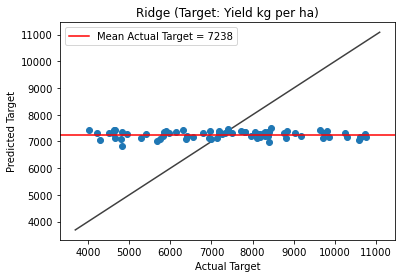

ElasticNet
MAE on test data: 1562.4848030964433
RMSE on test data: 1886.8751955018238
R squared on test data: -0.009920872361280475
MAPE on test data: 23.65666947537943


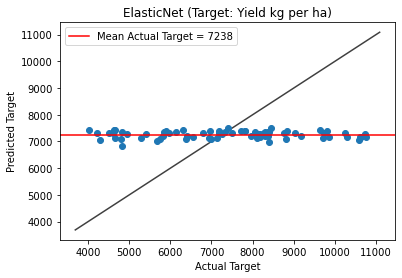

SVR
MAE on test data: 1556.7868682444216
RMSE on test data: 1899.0787628683288
R squared on test data: -0.02302666005323717
MAPE on test data: 23.603906589753322


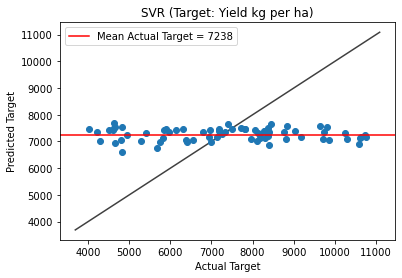

GBR
MAE on test data: 1455.416561295967
RMSE on test data: 1790.4307261221725
R squared on test data: 0.0906814685443782
MAPE on test data: 21.953819439708123


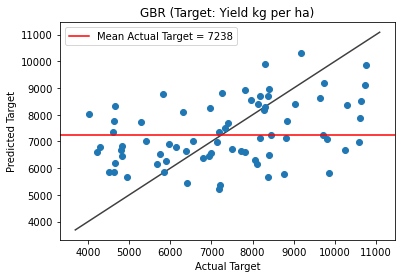

XGBoost
MAE on test data: 1470.973011158607
RMSE on test data: 1811.3929154613136
R squared on test data: 0.06926439731718204
MAPE on test data: 22.091388286569487


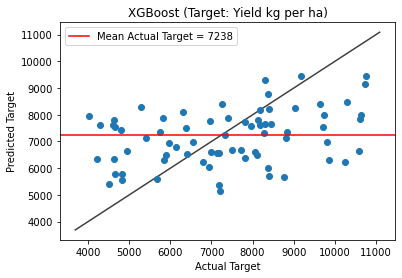

[17:06:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1332.7713255976912
RMSE on test data: 1619.9652331151071
R squared on test data: -0.016796395291186927
MAPE on test data: 20.682126071185237


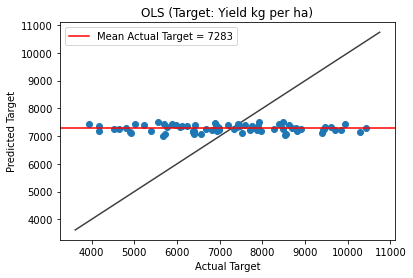

Lasso
MAE on test data: 1332.7924904845104
RMSE on test data: 1619.8793158179126
R squared on test data: -0.016688543493321495
MAPE on test data: 20.682717612759426


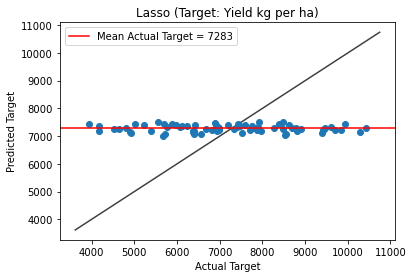

Ridge
MAE on test data: 1332.4835294282177
RMSE on test data: 1619.0793618505227
R squared on test data: -0.015684637576613314
MAPE on test data: 20.67515062083092


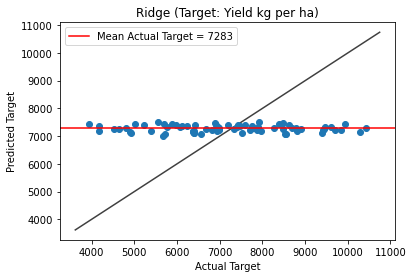

ElasticNet
MAE on test data: 1332.7898482110463
RMSE on test data: 1619.8898460394664
R squared on test data: -0.016701761750147703
MAPE on test data: 20.68264376955614


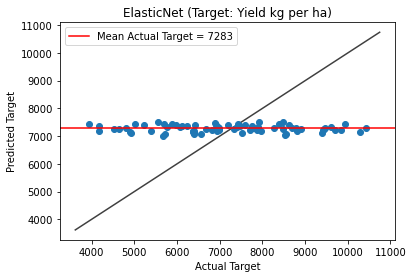

SVR
MAE on test data: 1328.0796129975733
RMSE on test data: 1618.624156996849
R squared on test data: -0.015113597523196187
MAPE on test data: 20.638639358236034


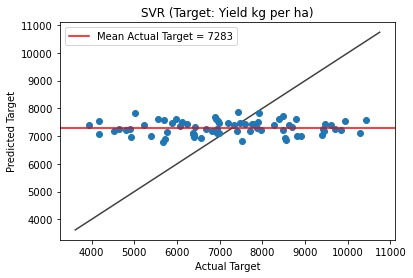

GBR
MAE on test data: 1672.080076961331
RMSE on test data: 2067.371399985915
R squared on test data: -0.6559972747615499
MAPE on test data: 25.27847457540171


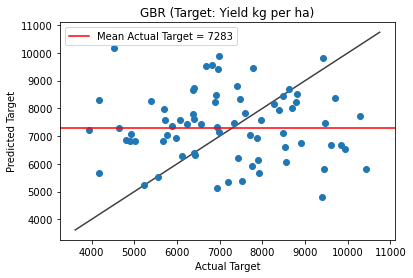

XGBoost
MAE on test data: 1533.8102541917774
RMSE on test data: 1943.6048736760715
R squared on test data: -0.4636544876524704
MAPE on test data: 22.99517302367574


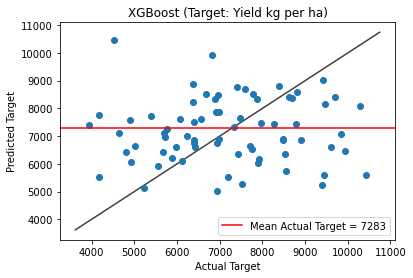

[17:06:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1443.4117981009545
RMSE on test data: 1795.3692590816781
R squared on test data: -0.06925315120437436
MAPE on test data: 22.246253003072


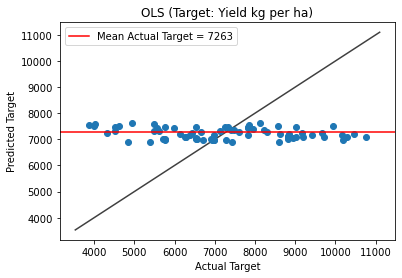

Lasso
MAE on test data: 1443.2485851279175
RMSE on test data: 1794.566036409846
R squared on test data: -0.06829662791496371
MAPE on test data: 22.242218943500017


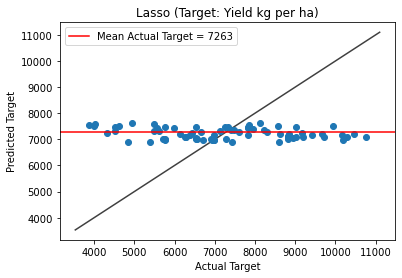

Ridge
MAE on test data: 1442.4761522841027
RMSE on test data: 1791.9462959650498
R squared on test data: -0.06517986647079277
MAPE on test data: 22.227260220013218


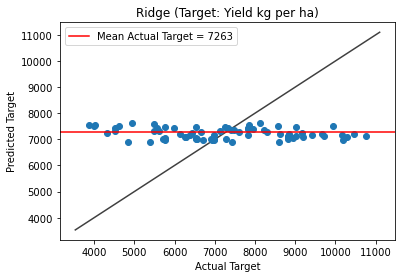

ElasticNet
MAE on test data: 1443.269004568599
RMSE on test data: 1794.666256118977
R squared on test data: -0.06841595187932348
MAPE on test data: 22.242723545540187


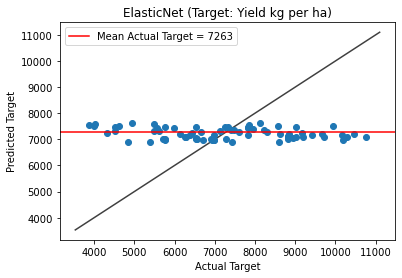

SVR
MAE on test data: 1432.2592245127025
RMSE on test data: 1788.2172675867207
R squared on test data: -0.06075121476761791
MAPE on test data: 22.138368800158418


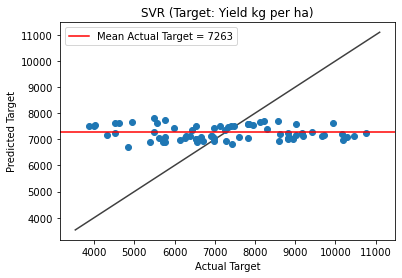

GBR
MAE on test data: 1531.405370590804
RMSE on test data: 1973.739557379336
R squared on test data: -0.29226820726975045
MAPE on test data: 23.565354047181053


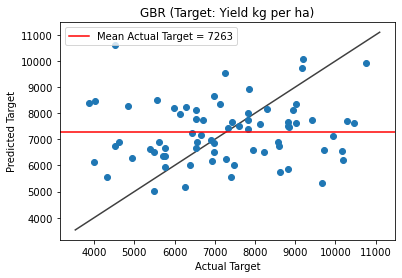

XGBoost
MAE on test data: 1465.1007939280144
RMSE on test data: 1825.6531145106126
R squared on test data: -0.10562918475796401
MAPE on test data: 22.185467689999918


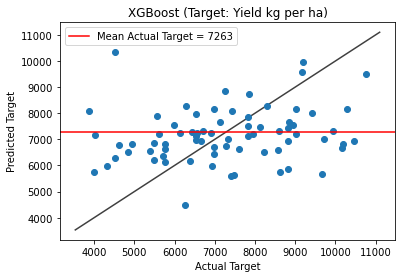

[17:06:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1494.4446896549812
RMSE on test data: 1811.6127717673119
R squared on test data: 0.00741150081527886
MAPE on test data: 23.05185864409084


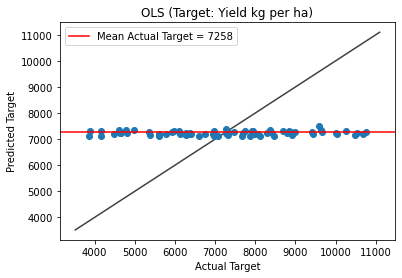

Lasso
MAE on test data: 1494.7399060025034
RMSE on test data: 1811.8152598117838
R squared on test data: 0.0071896007053882105
MAPE on test data: 23.056125000795763


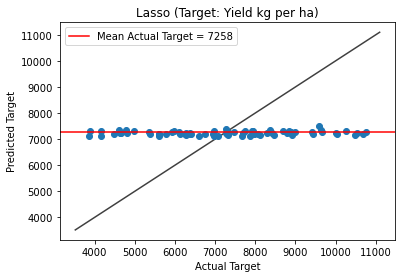

Ridge
MAE on test data: 1494.5049431806192
RMSE on test data: 1811.6759614890814
R squared on test data: 0.007342255901636063
MAPE on test data: 23.052162434261522


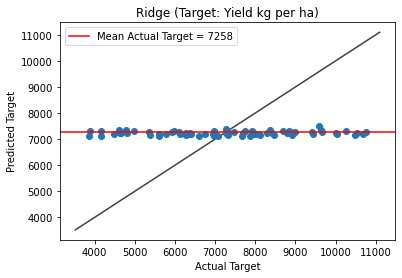

ElasticNet
MAE on test data: 1494.7030100172278
RMSE on test data: 1811.7897336961973
R squared on test data: 0.007217575317422842
MAPE on test data: 23.05559182752673


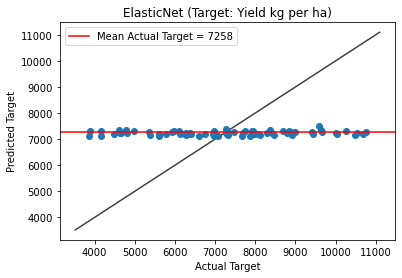

SVR
MAE on test data: 1467.1529196322106
RMSE on test data: 1791.1242210211128
R squared on test data: 0.029736029043064383
MAPE on test data: 22.59666240753883


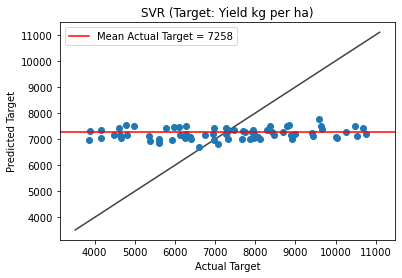

GBR
MAE on test data: 1601.6771883541383
RMSE on test data: 1940.4036558103965
R squared on test data: -0.13873497485563502
MAPE on test data: 25.085016775893916


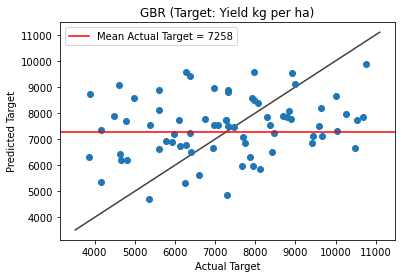

XGBoost
MAE on test data: 1580.5630330044726
RMSE on test data: 1888.190763104027
R squared on test data: -0.07827671986632545
MAPE on test data: 24.757420926631138


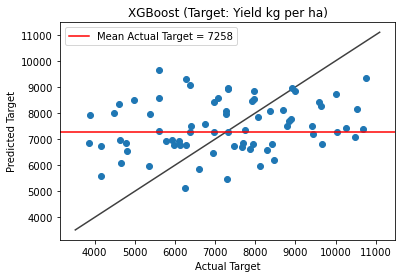

[17:07:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1081.5529790155113
RMSE on test data: 1312.3499829060215
R squared on test data: -0.034059908271997674
MAPE on test data: 15.43296640338613


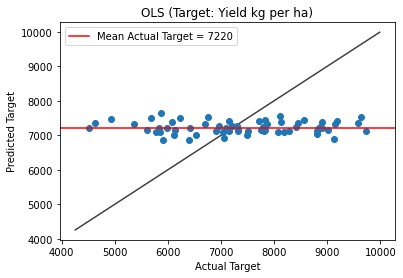

Lasso
MAE on test data: 1081.5892093153209
RMSE on test data: 1312.1026115742256
R squared on test data: -0.03367011489096594
MAPE on test data: 15.432709484888601


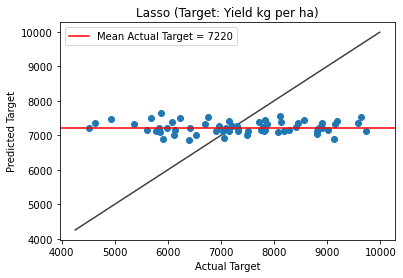

Ridge
MAE on test data: 1081.61894439864
RMSE on test data: 1311.3495908166137
R squared on test data: -0.03248400080210301
MAPE on test data: 15.427164744390911


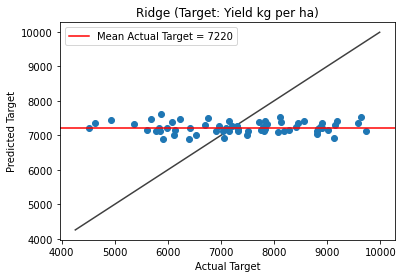

ElasticNet
MAE on test data: 1081.5846777665647
RMSE on test data: 1312.1332475488653
R squared on test data: -0.033718385294278175
MAPE on test data: 15.432741547650256


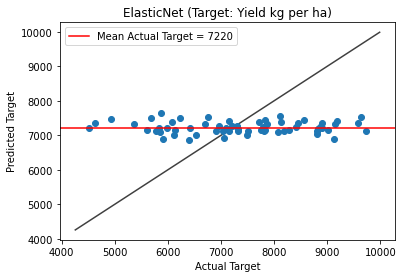

SVR
MAE on test data: 1101.753794372211
RMSE on test data: 1326.660836680572
R squared on test data: -0.05673521004023052
MAPE on test data: 15.680859415604399


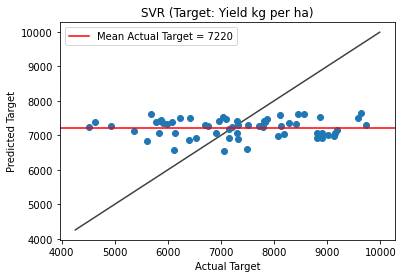

GBR
MAE on test data: 1269.4596108908604
RMSE on test data: 1594.1221036915588
R squared on test data: -0.5257716031034134
MAPE on test data: 18.669341519470663


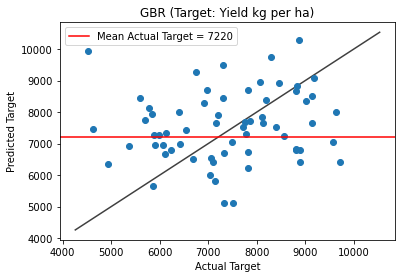

XGBoost
MAE on test data: 1160.7044640413374
RMSE on test data: 1460.2275983032516
R squared on test data: -0.2802284236529158
MAPE on test data: 17.21477079396076


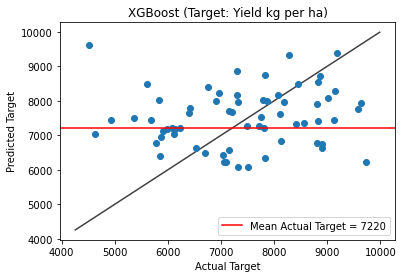

[17:07:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1047.9882268257834
RMSE on test data: 1289.0300338995787
R squared on test data: 0.0035929343633811506
MAPE on test data: 15.35818261691424


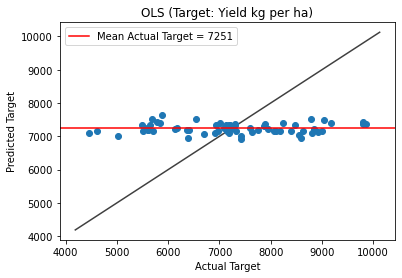

Lasso
MAE on test data: 1047.7559252812148
RMSE on test data: 1289.0996496129412
R squared on test data: 0.00348530698475058
MAPE on test data: 15.355288192311969


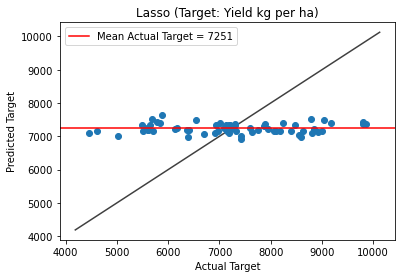

Ridge
MAE on test data: 1047.029566029198
RMSE on test data: 1288.971511293128
R squared on test data: 0.0036834070650695327
MAPE on test data: 15.345357594365227


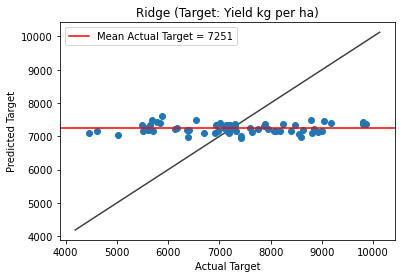

ElasticNet
MAE on test data: 1047.7849640947302
RMSE on test data: 1289.0906188623646
R squared on test data: 0.003499269045975417
MAPE on test data: 15.355650053098502


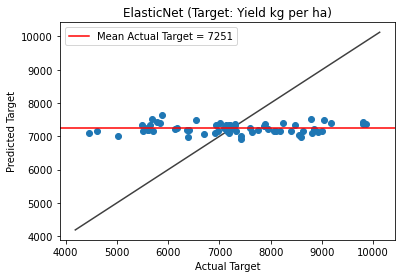

SVR
MAE on test data: 1083.259687152663
RMSE on test data: 1336.9197657247316
R squared on test data: -0.07181890786568634
MAPE on test data: 16.00713033809502


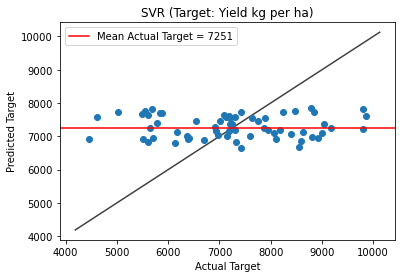

GBR
MAE on test data: 1323.7905364179828
RMSE on test data: 1599.735787404463
R squared on test data: -0.5346425896978528
MAPE on test data: 19.421996071475593


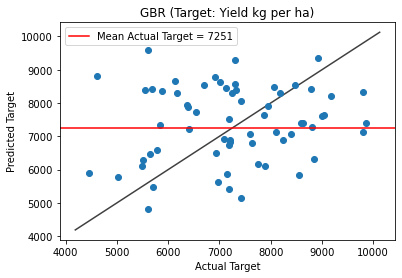

XGBoost
MAE on test data: 1242.9780870163972
RMSE on test data: 1480.4736854328714
R squared on test data: -0.31435327221575404
MAPE on test data: 18.148533512759542


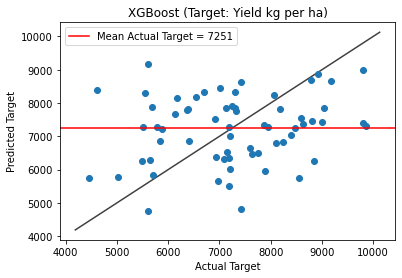

[17:08:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1333.3209951598024
RMSE on test data: 1556.598744472867
R squared on test data: 0.007343308282738437
MAPE on test data: 19.992795364492395


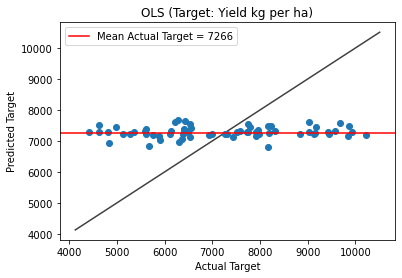

Lasso
MAE on test data: 1333.3531064306412
RMSE on test data: 1556.276193691273
R squared on test data: 0.007754652593031208
MAPE on test data: 19.992453229762802


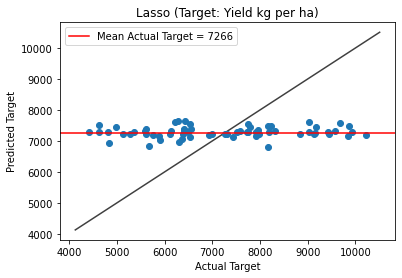

Ridge
MAE on test data: 1334.0280922178063
RMSE on test data: 1556.454028907268
R squared on test data: 0.0075278724775373895
MAPE on test data: 20.001872184397957


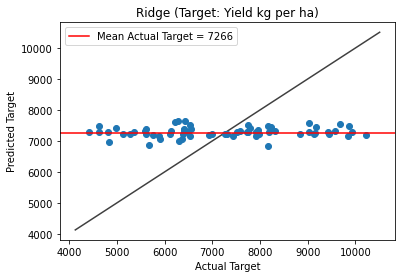

ElasticNet
MAE on test data: 1333.3490907552964
RMSE on test data: 1556.316136361105
R squared on test data: 0.007703718912923652
MAPE on test data: 19.99249598355219


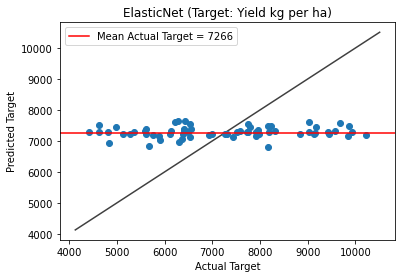

SVR
MAE on test data: 1337.9355957987684
RMSE on test data: 1564.8028275211786
R squared on test data: -0.003147897741994088
MAPE on test data: 19.925429785808593


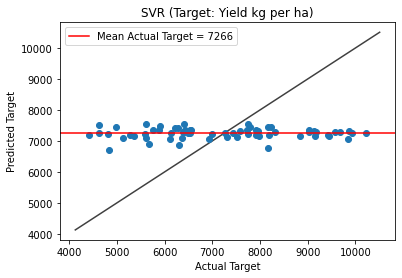

GBR
MAE on test data: 1220.2613575217974
RMSE on test data: 1577.3378976923864
R squared on test data: -0.019283980926496858
MAPE on test data: 18.69254491175807


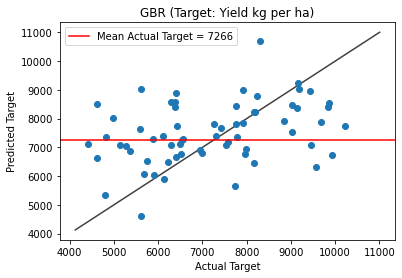

XGBoost
MAE on test data: 1209.2578897279175
RMSE on test data: 1548.127174960594
R squared on test data: 0.018118695088250147
MAPE on test data: 18.321610655847692


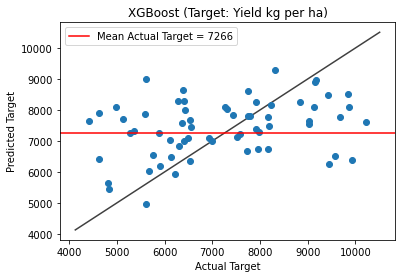

[17:08:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1297.8807441553854
RMSE on test data: 1519.9037136897678
R squared on test data: -0.052821199659376594
MAPE on test data: 20.729596923525996


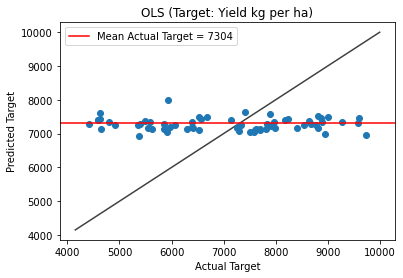

Lasso
MAE on test data: 1297.1663391080501
RMSE on test data: 1519.272611052989
R squared on test data: -0.051947064958131506
MAPE on test data: 20.71915333352988


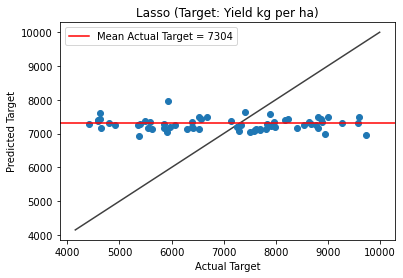

Ridge
MAE on test data: 1295.5503156878283
RMSE on test data: 1517.9369055722484
R squared on test data: -0.05009818834477886
MAPE on test data: 20.69548260077696


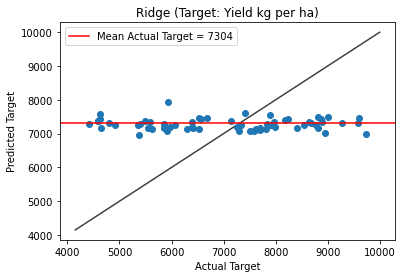

ElasticNet
MAE on test data: 1297.2556620747278
RMSE on test data: 1519.3508718526186
R squared on test data: -0.052055443583886696
MAPE on test data: 20.720459071745704


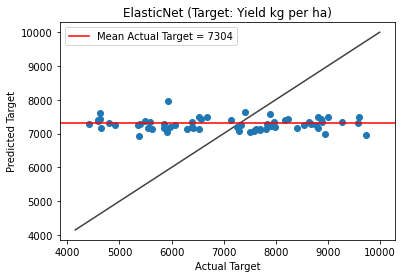

SVR
MAE on test data: 1296.947638714986
RMSE on test data: 1539.7107450733226
R squared on test data: -0.08044023866220984
MAPE on test data: 20.72976483036888


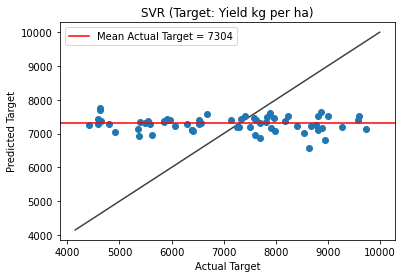

GBR
MAE on test data: 1504.84152504649
RMSE on test data: 1812.3957853831514
R squared on test data: -0.4970232874551419
MAPE on test data: 23.01139858255302


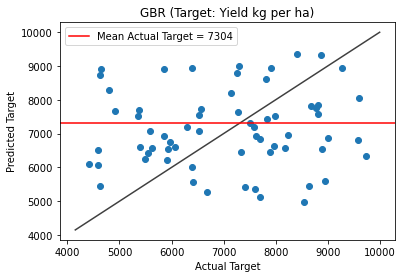

XGBoost
MAE on test data: 1405.8256127097775
RMSE on test data: 1701.5821037001763
R squared on test data: -0.31955740307924496
MAPE on test data: 21.83444609795838


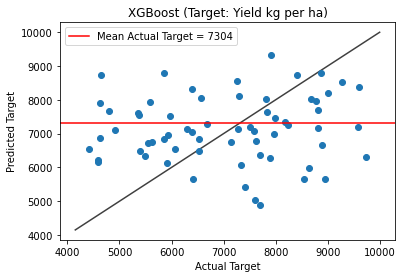

r_2_all_data  r_2_90_percentile  r_2_80_percentile
0     -0.061753           0.069264          -0.280228
1     -0.015211          -0.463654          -0.314353
2     -0.187209          -0.105629           0.018119
3     -0.010362          -0.078277          -0.319557

None


In [11]:
r_0_50 = build_models(df_dy_wy_ratio_summer_combined_parents, 0, 50)
r_0_60 = build_models(df_dy_wy_ratio_summer_combined_parents, 0, 60)
r_0_70 = build_models(df_dy_wy_ratio_summer_combined_parents, 0, 70)
r_0_80 = build_models(df_dy_wy_ratio_summer_combined_parents, 0, 80)
r_05_50 = build_models(df_dy_wy_ratio_summer_combined_parents, .05, 50)
r_05_60 = build_models(df_dy_wy_ratio_summer_combined_parents, .05, 60)
r_05_70 = build_models(df_dy_wy_ratio_summer_combined_parents, .05, 70)
r_05_80 = build_models(df_dy_wy_ratio_summer_combined_parents, .05, 80)
r_1_50 = build_models(df_dy_wy_ratio_summer_combined_parents, .1, 50)
r_1_60 = build_models(df_dy_wy_ratio_summer_combined_parents, .1, 60)
r_1_70 = build_models(df_dy_wy_ratio_summer_combined_parents, .1, 70)
r_1_80 = build_models(df_dy_wy_ratio_summer_combined_parents, .1, 80)

list0 = [r_0_50, r_0_60, r_0_70, r_0_80]
list05 = [r_05_50, r_05_60, r_05_70, r_05_80]
list1 = [r_1_50, r_1_60, r_1_70, r_1_80]

print(display(pd.DataFrame(data = {'r_2_all_data': list0, 'r_2_90_percentile': list05, 'r_2_80_percentile': list1})))

## Model Building Dataset 4: Winter Acceptable DY/WY Ratio Combined Parents

[17:08:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1363.4393655244417
RMSE on test data: 1709.8932643957446
R squared on test data: -0.0273270816063782
MAPE on test data: 24.481376068301078


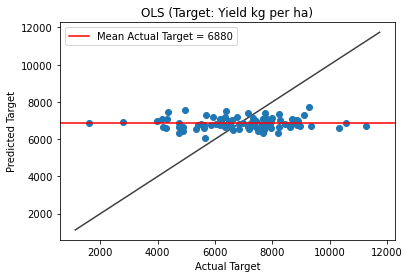

Lasso
MAE on test data: 1363.432888999492
RMSE on test data: 1709.7120245312299
R squared on test data: -0.027109310407168685
MAPE on test data: 24.48212624752167


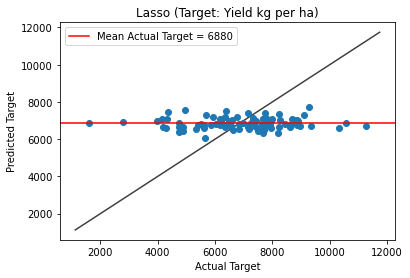

Ridge
MAE on test data: 1362.5280875504593
RMSE on test data: 1708.1946683783701
R squared on test data: -0.02528701631870911
MAPE on test data: 24.46970098343863


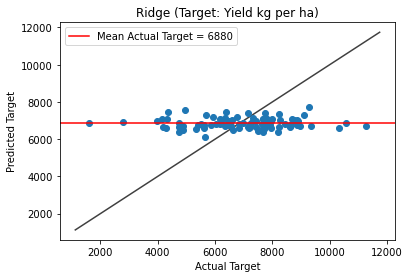

ElasticNet
MAE on test data: 1363.4336798631944
RMSE on test data: 1709.7342964119096
R squared on test data: -0.027136070241193577
MAPE on test data: 24.482032200837974


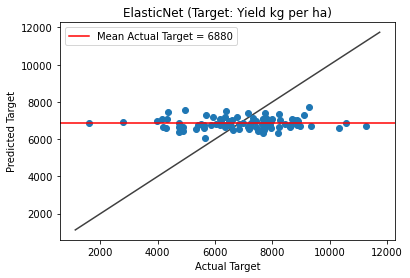

SVR
MAE on test data: 1342.512919134997
RMSE on test data: 1695.117791914949
R squared on test data: -0.009649183044847298
MAPE on test data: 24.135111972966282


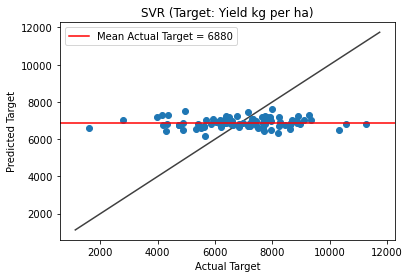

GBR
MAE on test data: 1408.9682191836341
RMSE on test data: 1847.6442238053905
R squared on test data: -0.1995198273599541
MAPE on test data: 24.240061082402146


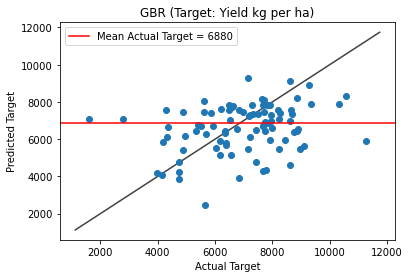

XGBoost
MAE on test data: 1387.4617857321311
RMSE on test data: 1766.3668664376462
R squared on test data: -0.09630792347624584
MAPE on test data: 23.86537136520804


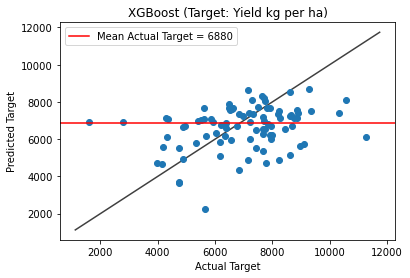

[17:09:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1573.4203258027749
RMSE on test data: 1867.1069058402227
R squared on test data: 0.00048534746788797545
MAPE on test data: 24.081426753508932


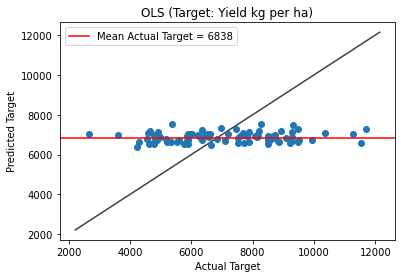

Lasso
MAE on test data: 1573.5290198899413
RMSE on test data: 1867.0549106562855
R squared on test data: 0.0005410156510159414
MAPE on test data: 24.084229820137438


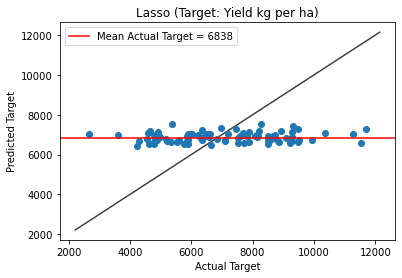

Ridge
MAE on test data: 1573.942586328887
RMSE on test data: 1867.0984965737246
R squared on test data: 0.0004943508796664275
MAPE on test data: 24.091445037128402


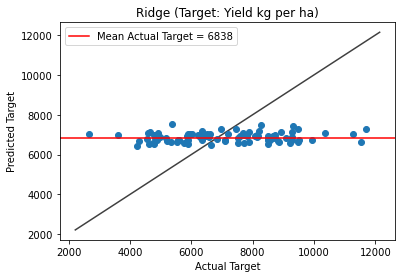

ElasticNet
MAE on test data: 1573.5022855519521
RMSE on test data: 1867.0581148749768
R squared on test data: 0.0005375851274802557
MAPE on test data: 24.083712894386558


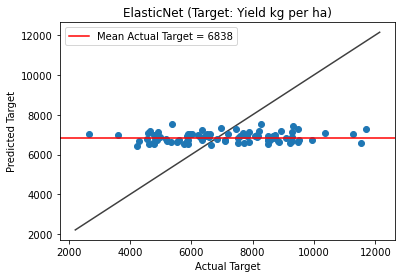

SVR
MAE on test data: 1550.1500348221482
RMSE on test data: 1860.2923570991438
R squared on test data: 0.007768070802549709
MAPE on test data: 23.938297909013404


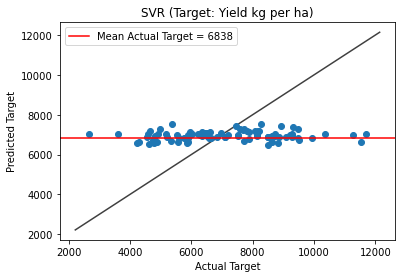

GBR
MAE on test data: 1612.979408391201
RMSE on test data: 1996.5635161815944
R squared on test data: -0.14292322052324025
MAPE on test data: 24.173663140566166


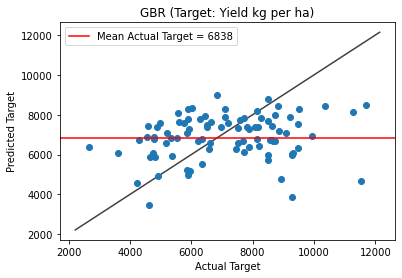

XGBoost
MAE on test data: 1511.0206975315252
RMSE on test data: 1855.3004592496281
R squared on test data: 0.013086025077008512
MAPE on test data: 22.41038789950679


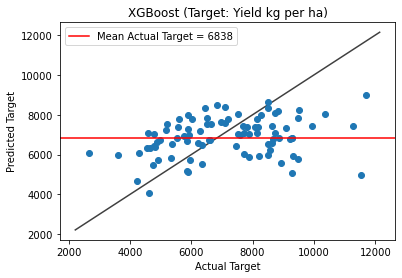

[17:09:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1388.8352047949188
RMSE on test data: 1754.5417631099845
R squared on test data: 0.004884514474801316
MAPE on test data: 22.272029122276383


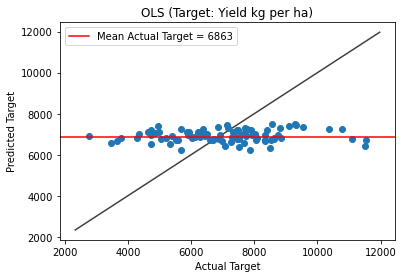

Lasso
MAE on test data: 1388.866610388581
RMSE on test data: 1754.426411802735
R squared on test data: 0.005015356727978482
MAPE on test data: 22.273632427150734


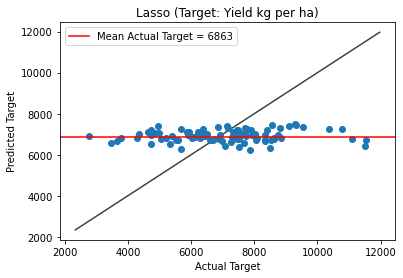

Ridge
MAE on test data: 1388.9461241501285
RMSE on test data: 1754.1369824534365
R squared on test data: 0.005343616724463152
MAPE on test data: 22.273164997939592


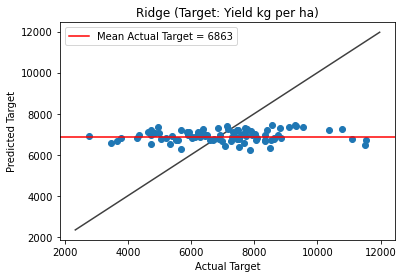

ElasticNet
MAE on test data: 1388.8626710755625
RMSE on test data: 1754.4402948688926
R squared on test data: 0.004999609709819941
MAPE on test data: 22.27343187661701


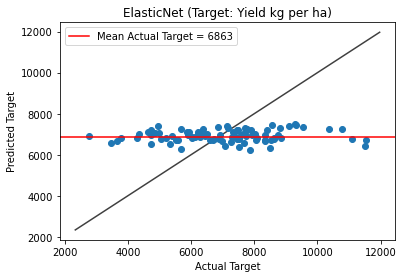

SVR
MAE on test data: 1361.4573654177702
RMSE on test data: 1731.562182714745
R squared on test data: 0.030780264313623906
MAPE on test data: 21.854041585740376


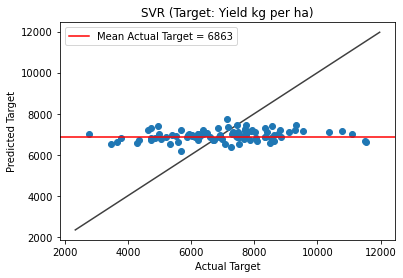

GBR
MAE on test data: 1467.6861043868273
RMSE on test data: 1866.5628653930785
R squared on test data: -0.12624093191317365
MAPE on test data: 23.21928640090867


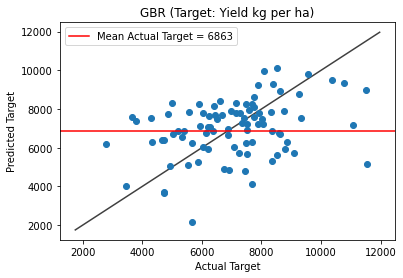

XGBoost
MAE on test data: 1346.1834176374032
RMSE on test data: 1727.5126368332803
R squared on test data: 0.0353083260983611
MAPE on test data: 21.533816419156928


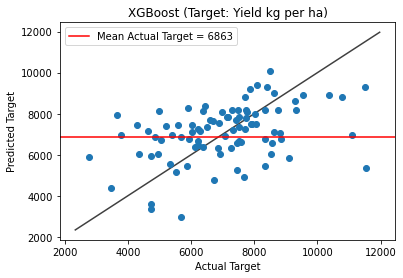

[17:09:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1417.1749354360645
RMSE on test data: 1780.563215645521
R squared on test data: -0.01030507548105497
MAPE on test data: 22.922478207408776


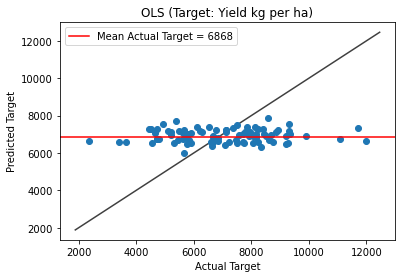

Lasso
MAE on test data: 1416.7786977481392
RMSE on test data: 1780.239109960635
R squared on test data: -0.009937308906935227
MAPE on test data: 22.918860522701596


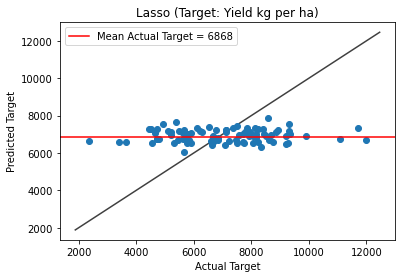

Ridge
MAE on test data: 1415.1890139482941
RMSE on test data: 1778.3501754369986
R squared on test data: -0.007795244566173087
MAPE on test data: 22.895833041478024


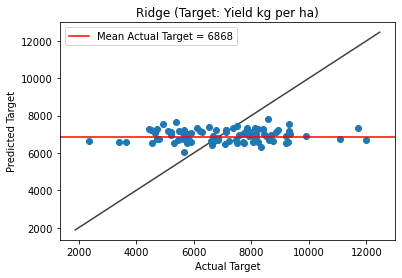

ElasticNet
MAE on test data: 1416.8242198476419
RMSE on test data: 1780.2790783851294
R squared on test data: -0.009982657934463512
MAPE on test data: 22.919258079675142


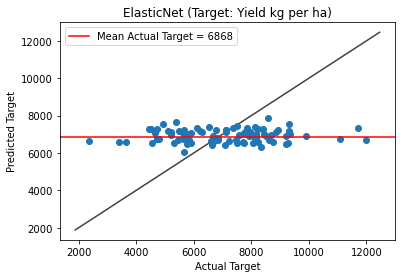

SVR
MAE on test data: 1396.6069550667448
RMSE on test data: 1751.998395835859
R squared on test data: 0.021850699024342335
MAPE on test data: 22.749242670532848


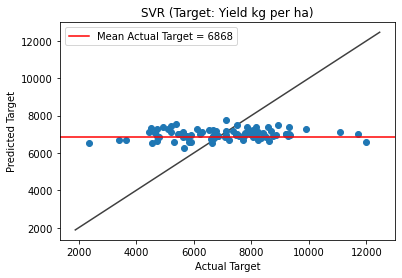

GBR
MAE on test data: 1434.390592376289
RMSE on test data: 1853.6178233644189
R squared on test data: -0.09490927324834608
MAPE on test data: 22.79518970937576


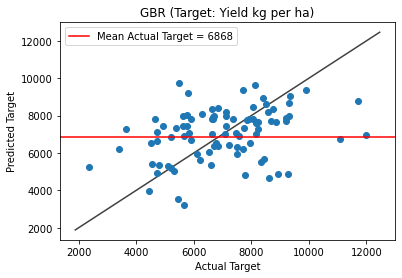

XGBoost
MAE on test data: 1385.536227595435
RMSE on test data: 1793.0522428222598
R squared on test data: -0.024527517413167388
MAPE on test data: 21.95183016075093


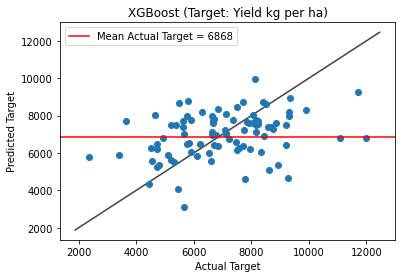

[17:10:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1123.5258846159104
RMSE on test data: 1381.4689448566878
R squared on test data: 0.001987774305027501
MAPE on test data: 18.315098524873076


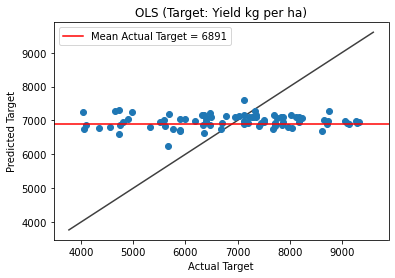

Lasso
MAE on test data: 1123.6577947669075
RMSE on test data: 1381.33901466336
R squared on test data: 0.002175495967459362
MAPE on test data: 18.31670875782628


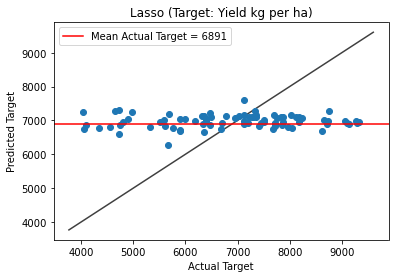

Ridge
MAE on test data: 1123.674260164715
RMSE on test data: 1380.5080966803291
R squared on test data: 0.0033755792892311565
MAPE on test data: 18.319010675982533


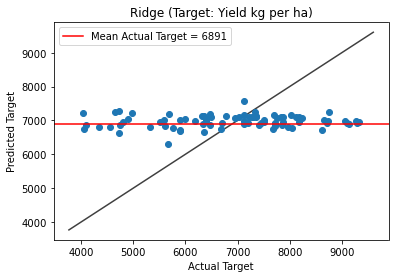

ElasticNet
MAE on test data: 1123.6413273321687
RMSE on test data: 1381.3549989553887
R squared on test data: 0.002152402996975944
MAPE on test data: 18.316507925049677


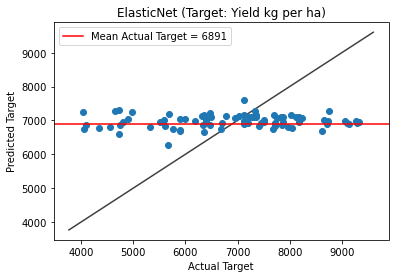

SVR
MAE on test data: 1112.2582844223223
RMSE on test data: 1378.4104028857257
R squared on test data: 0.006402036744837969
MAPE on test data: 18.114533825691556


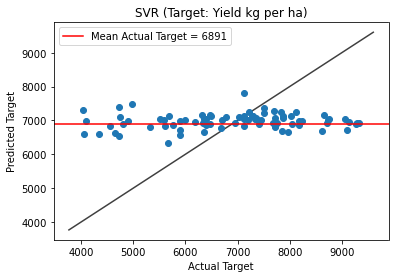

GBR
MAE on test data: 1258.7479246228777
RMSE on test data: 1552.3366857852711
R squared on test data: -0.2601593052131692
MAPE on test data: 18.99796359849064


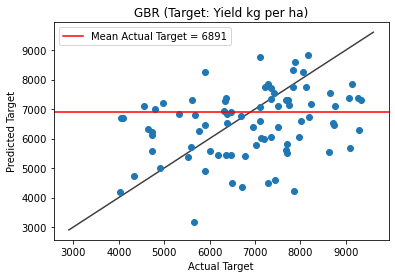

XGBoost
MAE on test data: 1093.8926413855613
RMSE on test data: 1357.9512285440678
R squared on test data: 0.035678270346205854
MAPE on test data: 16.747787889447586


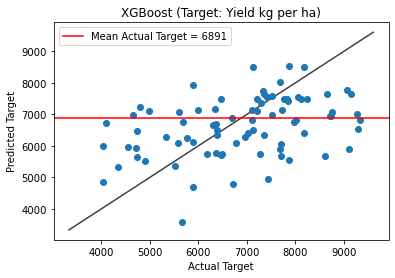

[17:10:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1179.8103697656402
RMSE on test data: 1447.8161824063118
R squared on test data: -0.05508041122797991
MAPE on test data: 19.431456448495577


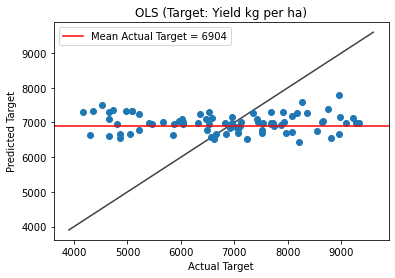

Lasso
MAE on test data: 1179.7920200876447
RMSE on test data: 1447.781200854214
R squared on test data: -0.055029426987108554
MAPE on test data: 19.431108394940097


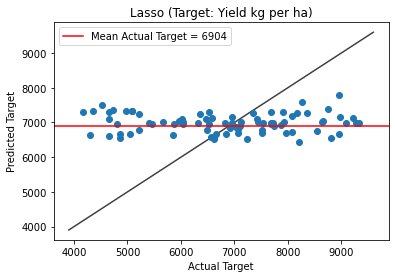

Ridge
MAE on test data: 1178.10316369315
RMSE on test data: 1444.0507052748126
R squared on test data: -0.04959944633988078
MAPE on test data: 19.395399898841294


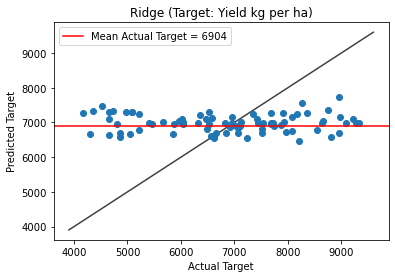

ElasticNet
MAE on test data: 1179.7802050069265
RMSE on test data: 1447.7584441802687
R squared on test data: -0.05499626068826724
MAPE on test data: 19.430882806659607


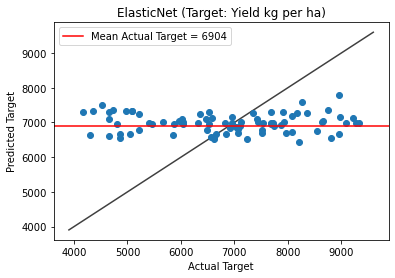

SVR
MAE on test data: 1164.6678174369536
RMSE on test data: 1439.6829281340752
R squared on test data: -0.04325966439456996
MAPE on test data: 19.11628497536716


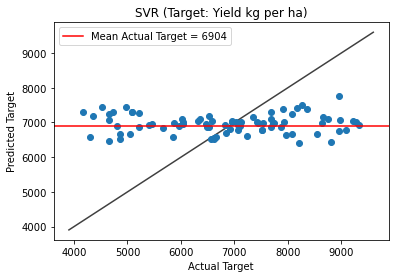

GBR
MAE on test data: 1229.4529000282494
RMSE on test data: 1582.7492997106876
R squared on test data: -0.260906742523743
MAPE on test data: 19.35637538078647


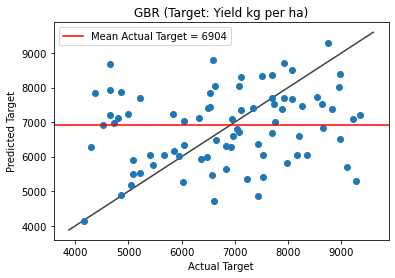

XGBoost
MAE on test data: 1174.5860808603911
RMSE on test data: 1499.07137416017
R squared on test data: -0.13110605993205549
MAPE on test data: 18.73253547551121


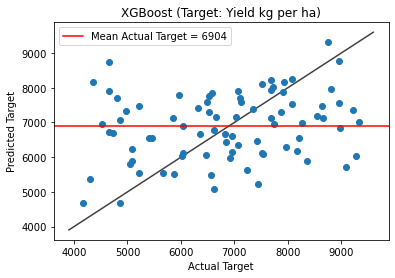

[17:11:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1084.5926082461267
RMSE on test data: 1301.5110935107487
R squared on test data: -0.019995022589248235
MAPE on test data: 17.342889581033774


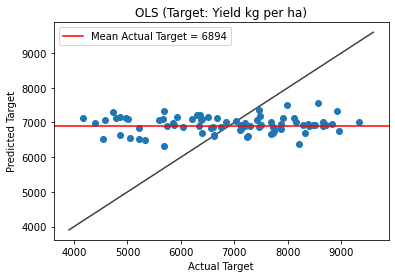

Lasso
MAE on test data: 1084.6090590175158
RMSE on test data: 1301.215454303173
R squared on test data: -0.01953168997072341
MAPE on test data: 17.3440625499293


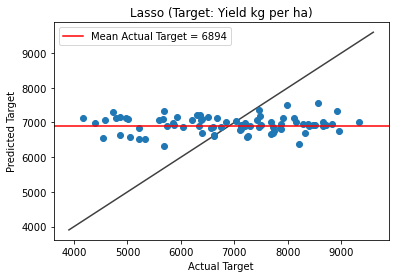

Ridge
MAE on test data: 1084.5532891752528
RMSE on test data: 1300.0794684883908
R squared on test data: -0.017752325946192027
MAPE on test data: 17.345295630023106


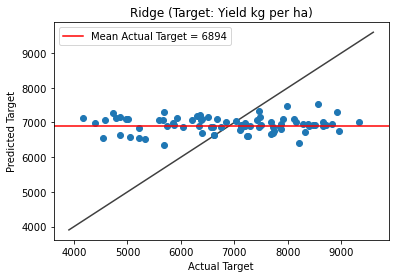

ElasticNet
MAE on test data: 1084.6070226874253
RMSE on test data: 1301.2521001503524
R squared on test data: -0.01958911647681849
MAPE on test data: 17.343916247567787


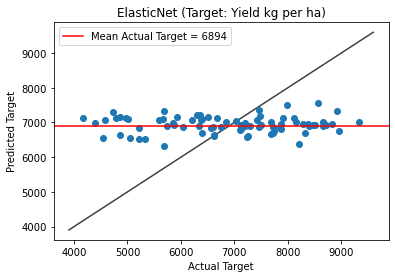

SVR
MAE on test data: 1059.4481026629508
RMSE on test data: 1283.2647248447943
R squared on test data: 0.008403884809413231
MAPE on test data: 17.029591340659437


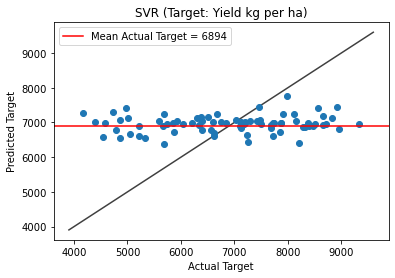

GBR
MAE on test data: 1039.232823293091
RMSE on test data: 1346.584031179238
R squared on test data: -0.09186570199734945
MAPE on test data: 15.95001884755397


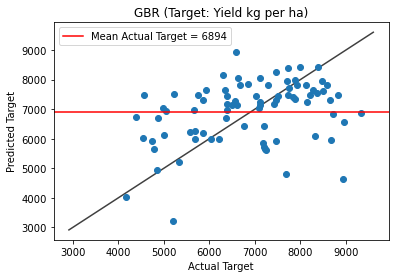

XGBoost
MAE on test data: 1055.9263580992117
RMSE on test data: 1316.964046088528
R squared on test data: -0.04435978781094163
MAPE on test data: 16.46208217453783


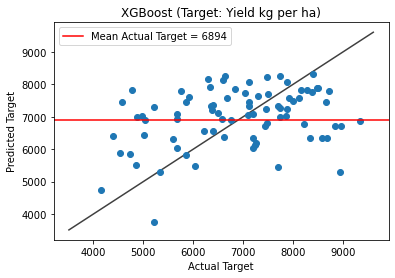

[17:11:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1131.4507980909802
RMSE on test data: 1393.0770718215176
R squared on test data: 0.038906715587104124
MAPE on test data: 18.619903387191215


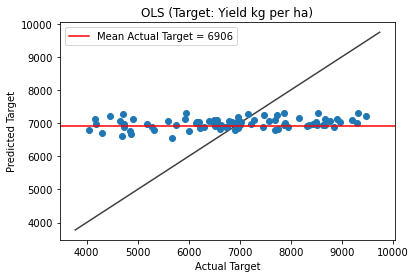

Lasso
MAE on test data: 1132.0835155114162
RMSE on test data: 1393.647768542805
R squared on test data: 0.03811909924215662
MAPE on test data: 18.629596658224


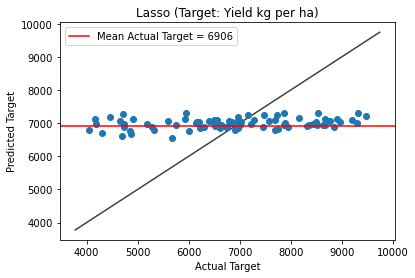

Ridge
MAE on test data: 1132.975637369584
RMSE on test data: 1394.6919166379182
R squared on test data: 0.03667723943973056
MAPE on test data: 18.643700052433445


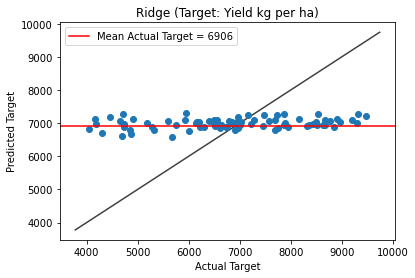

ElasticNet
MAE on test data: 1132.0044346945613
RMSE on test data: 1393.5761642514447
R squared on test data: 0.038217937747072384
MAPE on test data: 18.62838526085609


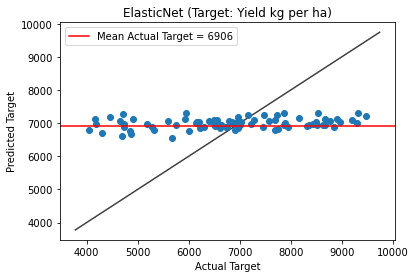

SVR
MAE on test data: 1133.3159138073725
RMSE on test data: 1398.1285706241072
R squared on test data: 0.0319239519339678
MAPE on test data: 18.83017716617906


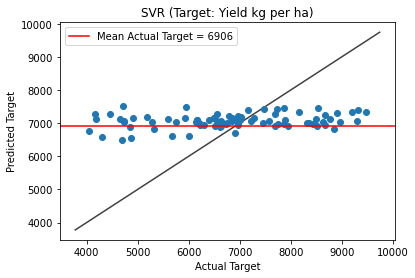

GBR
MAE on test data: 1161.789686169127
RMSE on test data: 1522.1849073157898
R squared on test data: -0.1474930846899769
MAPE on test data: 18.050513971666867


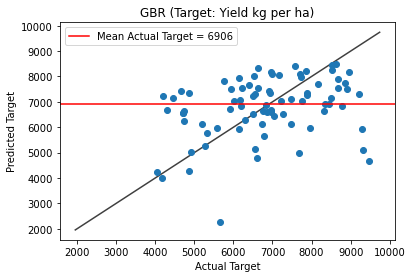

XGBoost
MAE on test data: 1154.3873940640717
RMSE on test data: 1466.1149119861823
R squared on test data: -0.06451375115662938
MAPE on test data: 18.212945629118877


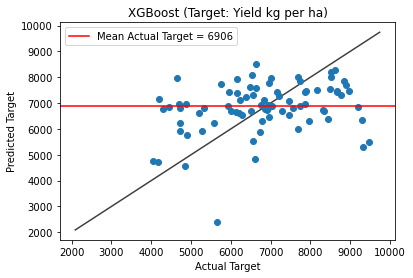

[17:11:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 947.0186284110262
RMSE on test data: 1154.7370500545373
R squared on test data: -0.04521919209443803
MAPE on test data: 15.197860007202879


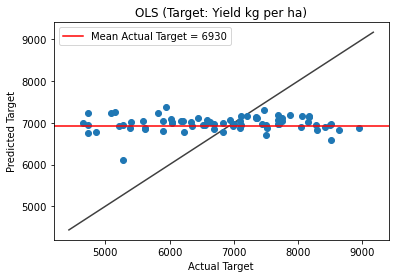

Lasso
MAE on test data: 947.0095025790591
RMSE on test data: 1154.3997292983465
R squared on test data: -0.044608624292138854
MAPE on test data: 15.198934685281198


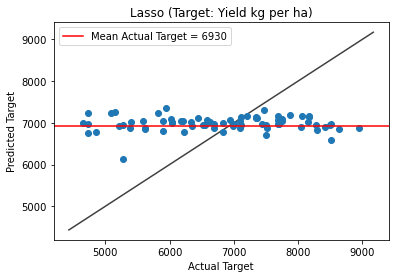

Ridge
MAE on test data: 947.2424087980113
RMSE on test data: 1153.2723349130797
R squared on test data: -0.04256927726173343
MAPE on test data: 15.208865906712388


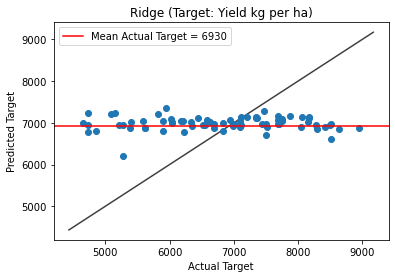

ElasticNet
MAE on test data: 947.0107172876451
RMSE on test data: 1154.4417007981895
R squared on test data: -0.04468458513417772
MAPE on test data: 15.19880148250847


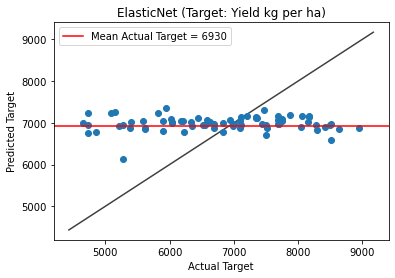

SVR
MAE on test data: 949.0897430895675
RMSE on test data: 1157.6624214872725
R squared on test data: -0.050521745509455984
MAPE on test data: 15.155908612861968


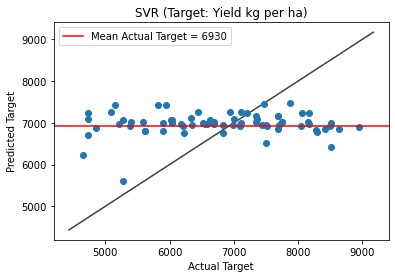

GBR
MAE on test data: 841.8221384859869
RMSE on test data: 1055.346557521898
R squared on test data: 0.12696557230970418
MAPE on test data: 13.146596820847744


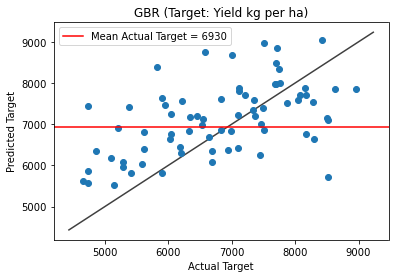

XGBoost
MAE on test data: 880.4204681202123
RMSE on test data: 1127.4947334135964
R squared on test data: 0.0035162556422175806
MAPE on test data: 13.903766030929374


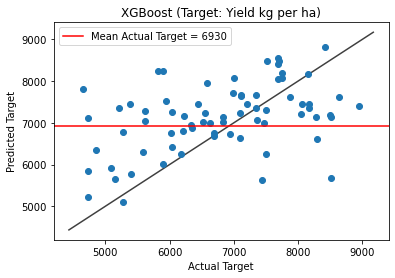

[17:12:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 897.998414185511
RMSE on test data: 1142.449127680503
R squared on test data: -0.07117736577004785
MAPE on test data: 13.885322180998646


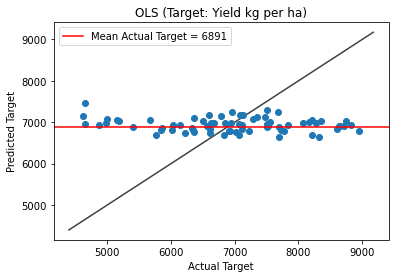

Lasso
MAE on test data: 897.9848759806566
RMSE on test data: 1142.425346971807
R squared on test data: -0.07113277193885015
MAPE on test data: 13.885150418251257


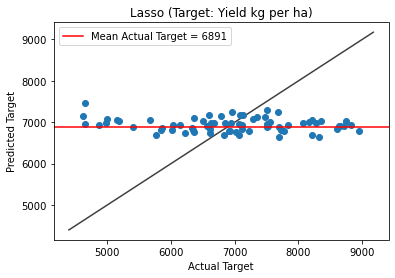

Ridge
MAE on test data: 895.8802199816154
RMSE on test data: 1139.262863333375
R squared on test data: -0.06521071972426351
MAPE on test data: 13.854925210622815


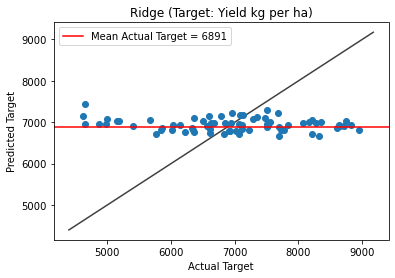

ElasticNet
MAE on test data: 897.9758309814697
RMSE on test data: 1142.4096977739164
R squared on test data: -0.07110342690733029
MAPE on test data: 13.885034147092368


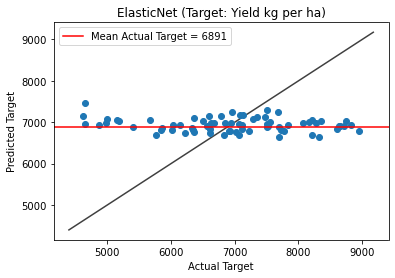

SVR
MAE on test data: 857.9870105177348
RMSE on test data: 1097.3613128998336
R squared on test data: 0.011704228937013839
MAPE on test data: 13.291844134887466


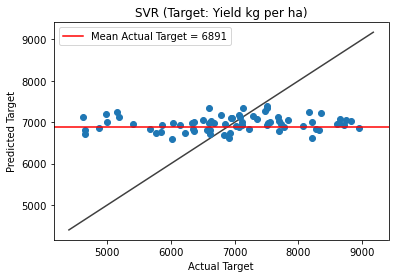

GBR
MAE on test data: 939.3778887937029
RMSE on test data: 1184.1778046970226
R squared on test data: -0.15085730854208945
MAPE on test data: 13.978038088024675


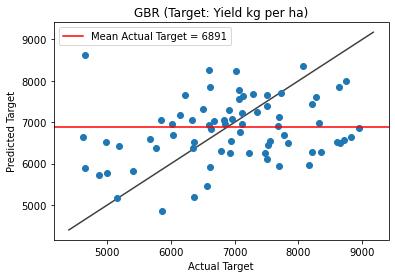

XGBoost
MAE on test data: 879.9556963410765
RMSE on test data: 1160.3451011144514
R squared on test data: -0.10499927388323416
MAPE on test data: 13.141059766317987


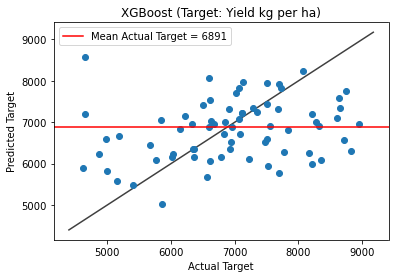

[17:12:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 979.7199327036885
RMSE on test data: 1188.7016896322996
R squared on test data: -0.0020485021562282046
MAPE on test data: 15.267167969695652


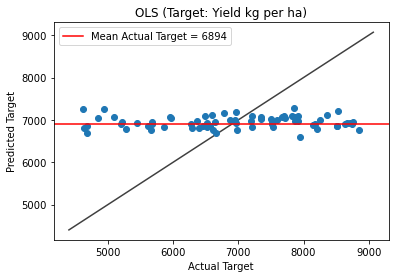

Lasso
MAE on test data: 980.1431493680429
RMSE on test data: 1188.9468015034788
R squared on test data: -0.002461792233096949
MAPE on test data: 15.274765514774675


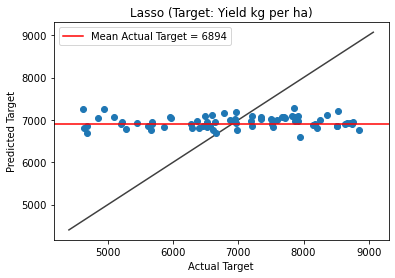

Ridge
MAE on test data: 980.4770430734983
RMSE on test data: 1188.6621470029413
R squared on test data: -0.0019818361897918635
MAPE on test data: 15.281241616426675


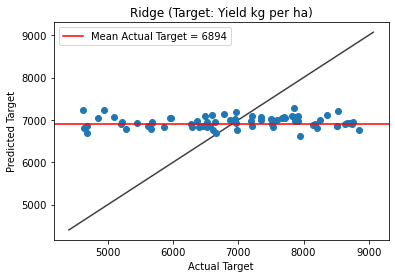

ElasticNet
MAE on test data: 980.0901893972979
RMSE on test data: 1188.9158514738908
R squared on test data: -0.0024096018100059347
MAPE on test data: 15.273815037066738


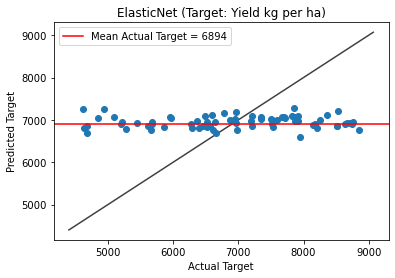

SVR
MAE on test data: 974.5786330608573
RMSE on test data: 1185.720897959345
R squared on test data: 0.002970676129586902
MAPE on test data: 15.242777411344063


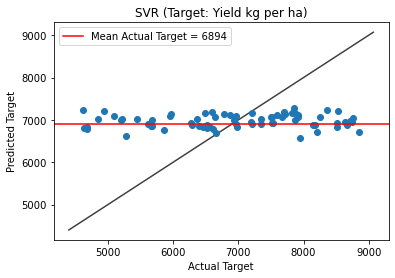

GBR
MAE on test data: 883.0007705571896
RMSE on test data: 1219.3454977669128
R squared on test data: -0.05437849925190075
MAPE on test data: 13.066451724608877


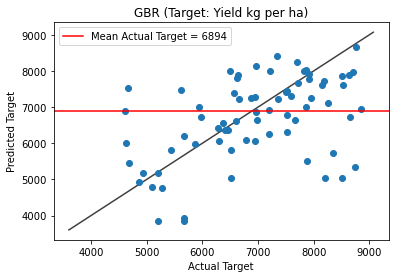

XGBoost
MAE on test data: 836.1113165627368
RMSE on test data: 1108.5658420063496
R squared on test data: 0.12850285552794205
MAPE on test data: 12.127630081532173


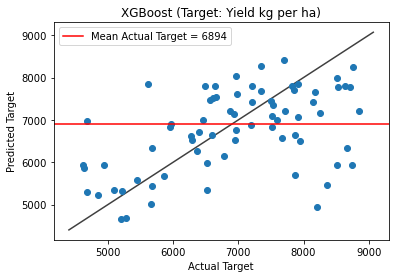

[17:12:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 953.1104808194555
RMSE on test data: 1137.2924368925728
R squared on test data: 0.03715658127966004
MAPE on test data: 14.570192480648553


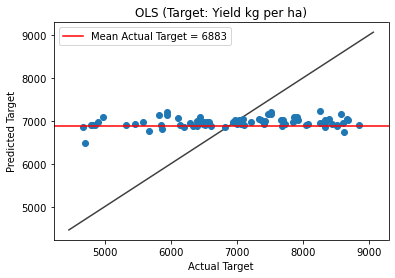

Lasso
MAE on test data: 953.605446096887
RMSE on test data: 1137.5820690434055
R squared on test data: 0.03666610774631707
MAPE on test data: 14.577005053571929


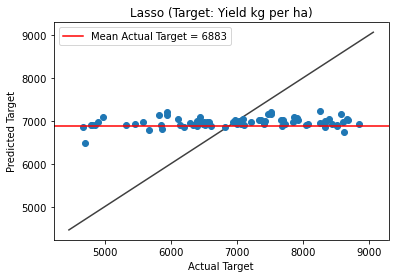

Ridge
MAE on test data: 954.4480674156914
RMSE on test data: 1138.0863087644648
R squared on test data: 0.03581191202306799
MAPE on test data: 14.589849213202754


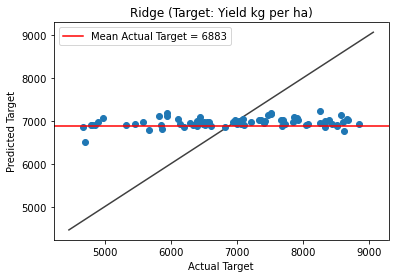

ElasticNet
MAE on test data: 953.5435826801173
RMSE on test data: 1137.5456138889358
R squared on test data: 0.03672784909069471
MAPE on test data: 14.57615369360685


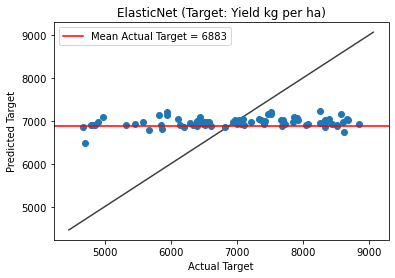

SVR
MAE on test data: 944.7933185998627
RMSE on test data: 1135.4895541847225
R squared on test data: 0.040206839574990494
MAPE on test data: 14.381810030271813


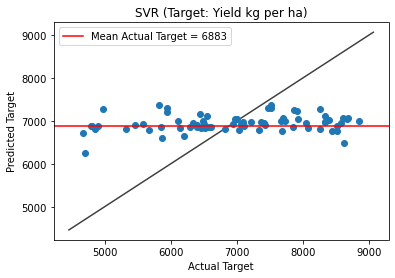

GBR
MAE on test data: 994.8082751021177
RMSE on test data: 1310.1194712691884
R squared on test data: -0.2777125679389425
MAPE on test data: 15.086000666509955


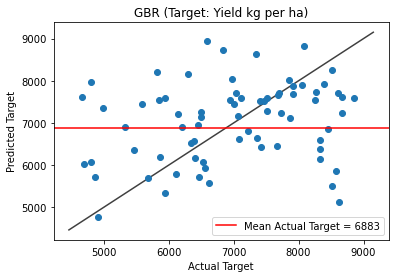

XGBoost
MAE on test data: 990.5333818674139
RMSE on test data: 1275.3665105486082
R squared on test data: -0.21082500678499816
MAPE on test data: 14.869933851920964


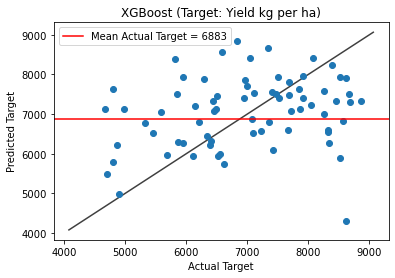

r_2_all_data  r_2_90_percentile  r_2_80_percentile
0     -0.096308           0.035678           0.003516
1      0.013086          -0.131106          -0.104999
2      0.035308          -0.044360           0.128503
3     -0.024528          -0.064514          -0.210825

None


In [12]:
r_0_50 = build_models(df_dy_wy_ratio_winter_combined_parents, 0, 50)
r_0_60 = build_models(df_dy_wy_ratio_winter_combined_parents, 0, 60)
r_0_70 = build_models(df_dy_wy_ratio_winter_combined_parents, 0, 70)
r_0_80 = build_models(df_dy_wy_ratio_winter_combined_parents, 0, 80)
r_05_50 = build_models(df_dy_wy_ratio_winter_combined_parents, .05, 50)
r_05_60 = build_models(df_dy_wy_ratio_winter_combined_parents, .05, 60)
r_05_70 = build_models(df_dy_wy_ratio_winter_combined_parents, .05, 70)
r_05_80 = build_models(df_dy_wy_ratio_winter_combined_parents, .05, 80)
r_1_50 = build_models(df_dy_wy_ratio_winter_combined_parents, .1, 50)
r_1_60 = build_models(df_dy_wy_ratio_winter_combined_parents, .1, 60)
r_1_70 = build_models(df_dy_wy_ratio_winter_combined_parents, .1, 70)
r_1_80 = build_models(df_dy_wy_ratio_winter_combined_parents, .1, 80)

list0 = [r_0_50, r_0_60, r_0_70, r_0_80]
list05 = [r_05_50, r_05_60, r_05_70, r_05_80]
list1 = [r_1_50, r_1_60, r_1_70, r_1_80]

print(display(pd.DataFrame(data = {'r_2_all_data': list0, 'r_2_90_percentile': list05, 'r_2_80_percentile': list1})))